# importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from uszipcode import SearchEngine

# for statistical analysis 
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


# To get diferent metric scores
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, f1_score
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')

# Removes the limit from the number of displayed rows.
pd.set_option("display.max_columns", None)
# Changes the limit of number of displayed columns tov200
pd.set_option("display.max_rows", 200)

# Read Dataset

In [2]:
df = pd.read_csv('Loan_Modelling.csv')

# copying the data to another dataframe

In [3]:
data = df.copy()

# view data first 10 rows

In [4]:
data.head(10)

ID  Age  Experience  Income  ZIPCode  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49    91107       4    1.6          1         0   
1   2   45          19      34    90089       3    1.5          1         0   
2   3   39          15      11    94720       1    1.0          1         0   
3   4   35           9     100    94112       1    2.7          2         0   
4   5   35           8      45    91330       4    1.0          2         0   
5   6   37          13      29    92121       4    0.4          2       155   
6   7   53          27      72    91711       2    1.5          2         0   
7   8   50          24      22    93943       1    0.3          3         0   
8   9   35          10      81    90089       3    0.6          2       104   
9  10   34           9     180    93023       1    8.9          3         0   

   Personal_Loan  Securities_Account  CD_Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1  
5              0                   0           0       1           0  
6              0                   0           0       1           0  
7              0                   0           0       0           1  
8              0                   0           0       1           0  
9              1                   0           0       0           0

#### ID is not significant factor in determining the personal_loan hence I will be dropping the column ID

In [5]:
data.drop('ID', inplace=True, axis=1)

# check info & null values if any

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   ZIPCode             5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   int64  
 7   Mortgage            5000 non-null   int64  
 8   Personal_Loan       5000 non-null   int64  
 9   Securities_Account  5000 non-null   int64  
 10  CD_Account          5000 non-null   int64  
 11  Online              5000 non-null   int64  
 12  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 507.9 KB


In [7]:
data.isnull().sum()

Age                   0
Experience            0
Income                0
ZIPCode               0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal_Loan         0
Securities_Account    0
CD_Account            0
Online                0
CreditCard            0
dtype: int64

#### Observation : 
- There are 13 columns and 5000 rows.
- None of the columns has empty values or null values.
- All the columns are type Integer except the column CCAvg which is float.

# check value counts in each column

In [8]:
for col in data.columns:
    print('value counts for the column {} are \n '.format(col),data[col].value_counts(dropna=False))
    print('\n\n')

value counts for the column Age are 
  35    151
43    149
52    145
58    143
54    143
50    138
41    136
30    136
56    135
34    134
39    133
59    132
57    132
51    129
60    127
45    127
46    127
42    126
40    125
31    125
55    125
62    123
29    123
61    122
44    121
32    120
33    120
48    118
38    115
49    115
47    113
53    112
63    108
36    107
37    106
28    103
27     91
65     80
64     78
26     78
25     53
24     28
66     24
23     12
67     12
Name: Age, dtype: int64



value counts for the column Experience are 
   32    154
 20    148
 9     147
 5     146
 23    144
 35    143
 25    142
 28    138
 18    137
 19    135
 26    134
 24    131
 3     129
 14    127
 16    127
 30    126
 34    125
 27    125
 17    125
 29    124
 22    124
 7     121
 8     119
 6     119
 15    119
 10    118
 33    117
 13    117
 11    116
 37    116
 36    114
 21    113
 4     113
 31    104
 12    102
 38     88
 39     85
 2      85
 1      74
 0      6

#### observation : 
- Experience column has some -ve numbers. 
- There are 467 unique zipcodes.
- No null values or missing so far.

# Pre-processing columns

#### Experience column has some data errors (negative numbers)  and there 467 unique zipcodes. zipcodes will be mapped to city name , state & county for better EDA analysis. 

#### 1. Experience

##### Negative values are not valid for experience hence converting them to positive by multiplying with -1.

In [9]:
# converting the negative values to positive.
data.loc[data[data['Experience']< 0].index,'Experience'] = data.loc[data[data['Experience']< 0].index,'Experience'].apply(lambda x: x*(-1))

#### 2. ZIPcode

##### Map the zip codes with city names & states by adding 3 new columns("state", "city_name", county)

In [10]:
# imported uszipcode library for mapping
search = SearchEngine(simple_zipcode=True) 
data['city_name']= data['ZIPCode'].apply(lambda x: search.by_zipcode(str(x)).major_city)
data['state']= data['ZIPCode'].apply(lambda x: search.by_zipcode(str(x)).state)
data['county']= data['ZIPCode'].apply(lambda x: search.by_zipcode(str(x)).county)

In [11]:
data.isnull().sum()

Age                    0
Experience             0
Income                 0
ZIPCode                0
Family                 0
CCAvg                  0
Education              0
Mortgage               0
Personal_Loan          0
Securities_Account     0
CD_Account             0
Online                 0
CreditCard             0
city_name             34
state                 34
county                34
dtype: int64

##### Observation : 
- 34 rows has null/Nan values for columns state, city name, county. Will be replaced with Unknown  

In [12]:
# check the count based on city county, state
columns = ['city_name','state','county']
for col in columns:
    print('value counts for the column {} are \n '.format(col),data[col].value_counts(dropna=False))
    print('\n\n')

value counts for the column city_name are 
  Los Angeles      375
San Diego        269
San Francisco    257
Berkeley         241
Sacramento       148
                ... 
Sierra Madre       1
Ladera Ranch       1
Sausalito          1
Tahoe City         1
Stinson Beach      1
Name: city_name, Length: 245, dtype: int64



value counts for the column state are 
  CA     4966
NaN      34
Name: state, dtype: int64



value counts for the column county are 
  Los Angeles County        1095
San Diego County           568
Santa Clara County         563
Alameda County             500
Orange County              339
San Francisco County       257
San Mateo County           204
Sacramento County          184
Santa Barbara County       154
Yolo County                130
Monterey County            128
Ventura County             114
San Bernardino County      101
Contra Costa County         85
Santa Cruz County           68
Riverside County            56
Marin County                54
Kern County    

In [13]:
# replace missing values with unknown
data['city_name'].fillna('unknown',inplace=True)
data['state'].fillna('unknown',inplace=True)
data['county'].fillna('unknown',inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   ZIPCode             5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   int64  
 7   Mortgage            5000 non-null   int64  
 8   Personal_Loan       5000 non-null   int64  
 9   Securities_Account  5000 non-null   int64  
 10  CD_Account          5000 non-null   int64  
 11  Online              5000 non-null   int64  
 12  CreditCard          5000 non-null   int64  
 13  city_name           5000 non-null   object 
 14  state               5000 non-null   object 
 15  county              5000 non-null   object 
dtypes: flo

##### Convert columns Family,education as category 

In [14]:
data['Family']=data['Family'].astype('category')
data['Education']=data['Education'].astype('category')

In [15]:
# removing the state column since it is all California and it does not have much significance with statistics
data.drop('state',axis=1,inplace=True)
# check the info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 5000 non-null   int64   
 1   Experience          5000 non-null   int64   
 2   Income              5000 non-null   int64   
 3   ZIPCode             5000 non-null   int64   
 4   Family              5000 non-null   category
 5   CCAvg               5000 non-null   float64 
 6   Education           5000 non-null   category
 7   Mortgage            5000 non-null   int64   
 8   Personal_Loan       5000 non-null   int64   
 9   Securities_Account  5000 non-null   int64   
 10  CD_Account          5000 non-null   int64   
 11  Online              5000 non-null   int64   
 12  CreditCard          5000 non-null   int64   
 13  city_name           5000 non-null   object  
 14  county              5000 non-null   object  
dtypes: category(2), float64(1), int64(10),

# Exploratory Data Analysis

In [16]:
data.describe().T

count          mean          std      min      25%  \
Age                 5000.0     45.338400    11.463166     23.0     35.0   
Experience          5000.0     20.134600    11.415189      0.0     10.0   
Income              5000.0     73.774200    46.033729      8.0     39.0   
ZIPCode             5000.0  93169.257000  1759.455086  90005.0  91911.0   
CCAvg               5000.0      1.937938     1.747659      0.0      0.7   
Mortgage            5000.0     56.498800   101.713802      0.0      0.0   
Personal_Loan       5000.0      0.096000     0.294621      0.0      0.0   
Securities_Account  5000.0      0.104400     0.305809      0.0      0.0   
CD_Account          5000.0      0.060400     0.238250      0.0      0.0   
Online              5000.0      0.596800     0.490589      0.0      0.0   
CreditCard          5000.0      0.294000     0.455637      0.0      0.0   

                        50%      75%      max  
Age                    45.0     55.0     67.0  
Experience             20.0     30.0     43.0  
Income                 64.0     98.0    224.0  
ZIPCode             93437.0  94608.0  96651.0  
CCAvg                   1.5      2.5     10.0  
Mortgage                0.0    101.0    635.0  
Personal_Loan           0.0      0.0      1.0  
Securities_Account      0.0      0.0      1.0  
CD_Account              0.0      0.0      1.0  
Online                  1.0      1.0      1.0  
CreditCard              0.0      1.0      1.0

#### Observations :
- Average age of the clients is ~45. maximum age - 67 and min 23
- Professional experience min has 0 and max has 43. we will have to look at this for more understanding.
- income has minimum 8K per year which is too low for living. 
- CCAvg usage has min 0 max 10k. credit card usage 10k per month seems too high.
- Mortgage has min 0 and maximum 635k. This column we need to take a look for more understanding.

In [17]:
# check Experience column for 0 professional experience
data[data['Experience']==0].head(30)

Age  Experience  Income  ZIPCode Family  CCAvg Education  Mortgage  \
105    24           0      35    94704      3   0.10         2         0   
151    26           0     132    92834      3   6.50         3         0   
155    24           0      60    94596      4   1.60         1         0   
156    26           0      15    92131      4   0.40         1         0   
160    29           0     134    95819      4   6.50         3         0   
182    24           0     135    95133      1   1.50         1         0   
256    26           0      99    92697      4   2.30         3         0   
347    25           0      43    94305      2   1.60         3         0   
363    25           0      30    92691      2   1.70         2         0   
379    25           0      28    92093      2   1.70         2         0   
418    27           0      33    90089      4   1.00         3         0   
466    25           0      13    91342      2   0.90         3         0   
495    25           0      44    94545      4   0.60         2         0   
873    24           0      88    90740      3   0.80         1       134   
1057   30           0      63    95503      2   1.75         3         0   
1181   25           0      65    90095      4   0.20         1         0   
1337   26           0     179    92028      4   2.10         2         0   
1732   25           0      88    94566      2   1.80         2       319   
1765   26           0     149    95051      2   7.20         1       154   
1847   25           0      52    95126      3   2.60         3       159   
2009   25           0      99    92735      1   1.90         1       323   
2157   25           0      71    93727      4   0.20         1        78   
2165   27           0      38    95929      4   1.00         3       154   
2241   26           0      14    94301      4   0.40         1        94   
2259   24           0      82    90401      3   0.80         1         0   
2417   25           0      53    90095      2   1.60         3         0   
2648   26           0     155    93105      2   7.20         1         0   
2652   24           0      44    90089      4   1.60         1       180   
2756   27           0      40    91301      4   1.00         3         0   
3075   26           0      85    95616      2   1.60         3         0   

      Personal_Loan  Securities_Account  CD_Account  Online  CreditCard  \
105               0                   1           0       1           0   
151               1                   0           0       0           1   
155               0                   0           0       1           0   
156               0                   0           0       0           1   
160               1                   0           0       0           0   
182               0                   0           0       1           0   
256               0                   0           0       0           1   
347               0                   1           1       1           1   
363               0                   0           0       0           0   
379               0                   0           0       0           0   
418               0                   0           0       0           0   
466               0                   0           0       1           0   
495               0                   0           0       1           1   
873               0                   0           0       0           0   
1057              0                   0           0       1           0   
1181              0                   1           0       0           0   
1337              1                   0           0       0           0   
1732              0                   0           0       1           1   
1765              0                   0           0       0           0   
1847              0                   0           0       0           0   
2009              0                   0           0       0           0   

#### observation :
- Experience is 0 but they have income(employment) which is little odd.

In [18]:
# check income column.
data.sort_values(by=["Income"], ascending=True).head(30)

Age  Experience  Income  ZIPCode Family  CCAvg Education  Mortgage  \
1054   63          38       8    95136      4   0.60         2         0   
1197   48          23       8    92866      1   0.40         3         0   
939    56          32       8    93943      2   0.30         1         0   
2591   31           7       8    95131      4   0.70         2         0   
2905   64          40       8    94110      2   0.30         3         0   
4416   49          25       8    94720      1   0.30         1        97   
2248   63          37       8    94618      1   0.80         2        97   
2354   35           9       8    94043      1   0.40         2         0   
1472   34           8       8    94710      3   0.10         2        83   
3718   45          19       8    92833      2   0.10         3         0   
1482   60          35       8    94143      1   0.10         1         0   
1720   52          28       8    95060      1   0.30         1         0   
4094   53          23       8    95616      4   0.40         3         0   
4507   26           1       8    94550      2   0.90         3         0   
50     32           8       8    92093      4   0.70         2         0   
1000   59          35       8    92691      4   0.70         1        91   
801    47          23       8    92612      4   0.20         1         0   
2509   36          11       8    93401      4   0.20         3        81   
2695   40          15       8    94960      2   0.10         2         0   
2347   64          39       8    92104      3   0.10         3        87   
4223   53          26       8    94709      1   0.50         2         0   
291    43          16       8    90089      3   0.67         2        88   
4706   60          36       8    92626      2   1.00         1         0   
1771   46          21       9    95023      2   0.70         3         0   
3606   43          18       9    96145      2   0.00         3        96   
4044   36          11       9    90266      2   0.30         2        99   
4657   41          16       9    90089      2   0.30         2         0   
3254   61          37       9    93907      2   0.30         3         0   
2218   38          13       9    92634      2   0.30         2         0   
1817   36          11       9    94604      4   0.20         3         0   

      Personal_Loan  Securities_Account  CD_Account  Online  CreditCard  \
1054              0                   0           0       1           0   
1197              0                   0           0       0           1   
939               0                   0           0       1           1   
2591              0                   0           0       0           0   
2905              0                   0           0       1           0   
4416              0                   0           0       0           0   
2248              0                   0           0       1           0   
2354              0                   0           0       1           0   
1472              0                   0           0       1           0   
3718              0                   0           0       0           1   
1482              0                   0           0       1           0   
1720              0                   0           0       1           0   
4094              0                   1           0       1           0   
4507              0                   0           0       0           1   
50                0                   1           0       1           0   
1000              0                   1           0       0           0   
801               0                   0           0       1           0   
2509              0                   0           0       0           1   
2695              0                   0           0       0           0   
2347              0                   0           0       0           1   
4223              0                   0           0       0           1   

#### Observation :
- Few clients has income very low but they have mortgages more than 5 times of their salary. 

In [19]:
# check CCAvg
data.sort_values(by=['CCAvg'],ascending=False).head(30)

Age  Experience  Income  ZIPCode Family  CCAvg Education  Mortgage  \
787    45          15     202    91380      3   10.0         3         0   
2101   35           5     203    95032      1   10.0         3         0   
2337   43          16     201    95054      1   10.0         2         0   
3943   61          36     188    91360      1    9.3         2         0   
3822   63          33     178    91768      4    9.0         3         0   
1339   52          25     180    94545      2    9.0         2       297   
9      34           9     180    93023      1    8.9         3         0   
2769   33           9     183    91320      2    8.8         3       582   
2447   44          19     201    95819      2    8.8         1         0   
917    45          20     200    90405      2    8.8         1         0   
3804   47          22     203    95842      2    8.8         1         0   
4225   43          18     204    91902      2    8.8         1         0   
881    44          19     154    92116      2    8.8         1         0   
2988   46          21     205    95762      2    8.8         1       181   
3312   47          22     190    94550      2    8.8         1         0   
1277   45          20     194    92110      2    8.8         1       428   
4156   37          12     193    92780      1    8.6         1         0   
3384   36          11     162    94583      1    8.6         1       153   
1354   35          10     179    91942      1    8.6         1       357   
4937   33           8     162    94960      1    8.6         1         0   
4603   37          12     179    91768      1    8.6         1         0   
614    37          12     180    90034      1    8.6         1         0   
1797   35          10     143    91365      1    8.6         1         0   
2952   33           8     182    94065      1    8.6         1         0   
4414   33           8     178    94720      3    8.5         1         0   
2041   45          20     180    95403      3    8.5         2       535   
1824   49          23     194    94022      4    8.3         2         0   
462    29           4     183    91423      3    8.3         3         0   
2812   53          28     183    96008      3    8.2         3       467   
2852   54          29     183    93105      1    8.1         1         0   

      Personal_Loan  Securities_Account  CD_Account  Online  CreditCard  \
787               1                   0           0       0           0   
2101              1                   0           0       0           0   
2337              1                   0           0       0           1   
3943              1                   0           0       0           0   
3822              1                   0           0       0           0   
1339              1                   0           0       1           0   
9                 1                   0           0       0           0   
2769              1                   0           0       1           0   
2447              0                   0           0       1           1   
917               0                   0           0       1           1   
3804              0                   0           0       1           0   
4225              0                   0           0       1           0   
881               0                   0           0       1           0   
2988              0                   1           0       1           0   
3312              0                   0           0       0           0   
1277              0                   0           0       0           0   
4156              0                   0           0       0           0   
3384              0                   1           0       1           0   
1354              0                   0           0       0           0   
4937              0                   0           1       1           1   
4603              0                   0           0       1           0   

#### Observation :
- people have good income who has high CCAvg.

In [20]:
# Check Mortgage
data.sort_values(by=['Mortgage'], ascending=False).head(30)

Age  Experience  Income  ZIPCode Family  CCAvg Education  Mortgage  \
2934   37          13     195    91763      2    6.5         1       635   
303    49          25     195    95605      4    3.0         1       617   
4812   29           4     184    92126      4    2.2         3       612   
1783   53          27     192    94720      1    1.7         1       601   
4842   49          23     174    95449      3    4.6         2       590   
1937   51          25     181    95051      1    3.3         3       589   
782    54          30     194    92056      3    6.0         3       587   
2769   33           9     183    91320      2    8.8         3       582   
4655   33           7     188    95054      2    7.0         2       581   
4345   26           1     184    94608      2    4.2         3       577   
4585   35          11     180    94010      1    3.6         3       571   
2541   34           8     171    90212      2    2.2         2       569   
1789   44          20     171    91330      4    0.7         1       567   
1716   32           8     200    91330      2    6.5         1       565   
2841   37          11     190    94305      4    7.3         2       565   
3608   59          35     202    94025      1    4.7         1       553   
4672   52          26     180    95831      1    1.7         1       550   
473    64          39     182    93955      1    1.2         2       547   
4859   34           8     165    91107      1    7.0         3       541   
2041   45          20     180    95403      3    8.5         2       535   
952    44          20     180    93943      2    7.6         1       524   
2956   62          38     195    91125      4    5.2         3       522   
4240   39          14     161    95064      1    4.1         1       509   
3515   50          26     148    94143      2    0.4         1       508   
2394   42          18     145    94065      2    8.0         1       505   
3662   35           9     164    94305      2    0.0         1       500   
2989   42          18     142    93106      1    3.4         1       496   
570    49          25     161    94928      3    6.5         2       485   
1372   39          13     139    95616      3    3.4         1       483   
4294   58          34     150    92110      1    7.4         1       481   

      Personal_Loan  Securities_Account  CD_Account  Online  CreditCard  \
2934              0                   0           0       1           0   
303               1                   0           0       0           0   
4812              1                   0           0       1           0   
1783              0                   0           0       1           0   
4842              1                   0           0       0           0   
1937              1                   1           1       1           0   
782               1                   1           1       1           1   
2769              1                   0           0       1           0   
4655              1                   0           0       0           0   
4345              1                   0           1       1           1   
4585              1                   0           1       1           1   
2541              1                   0           0       1           0   
1789              1                   0           1       1           1   
1716              0                   0           0       1           0   
2841              1                   0           1       1           0   
3608              0                   0           0       0           0   
4672              0                   0           0       1           0   
473               1                   0           0       1           0   
4859              1                   0           0       0           0   
2041              1                   0           0       0           0   
952               0                   0           0       0           1   

#### Observation :
- people who has high mortgage has better income.

# Distributions / Univariate / Bivariate Analysis

In [21]:
def histogram_boxplot(feature, figsize=(15,10), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    sns.set(font_scale=2) # setting the font scale  of the seaborn
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='red') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=F, ax=ax_hist2, bins=bins) if bins else sns.distplot(feature, kde=False, ax=ax_hist2) # For histogram
    ax_hist2.axvline(feature.mean(), color='g', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(feature.median(), color='black', linestyle='-') # Add median to the histogram

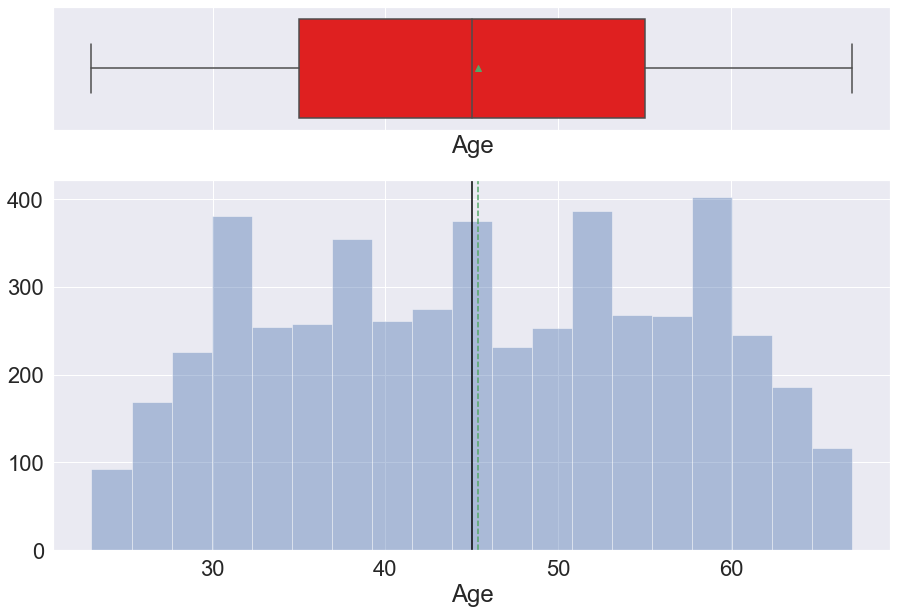

In [22]:
# boxplot and histogram for column Age
histogram_boxplot(data.Age)

#### Observation :
- Most of the customers of age ~30, ~45, ~52, ~60.
- Mean and median are almost same

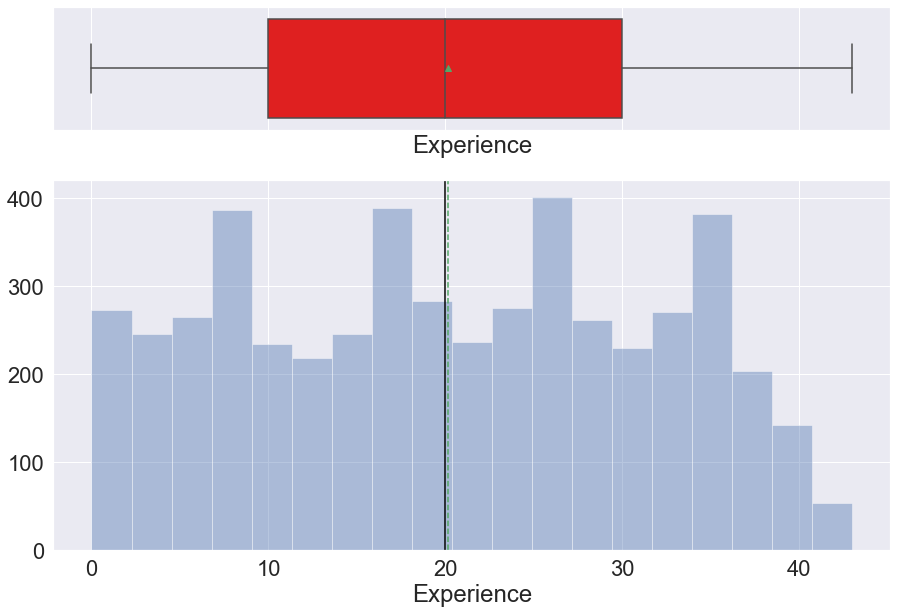

In [23]:
# boxplot and histogram for column Experience
histogram_boxplot(data.Experience)

#### Observation : 
- custmors with experiences ~8, ~18, ~26, ~34 are more in number.

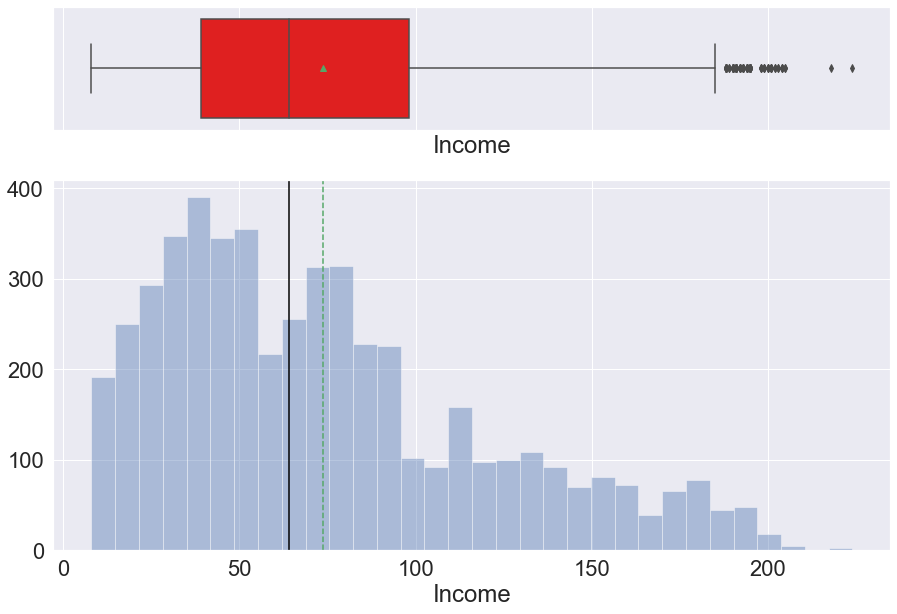

In [24]:
# boxplot and histogram for column Income
histogram_boxplot(data.Income)

#### Observation :
- income is right skewed.
- most of the customers are having income below 100K
- there are some outliers. we will need to treat these outliers

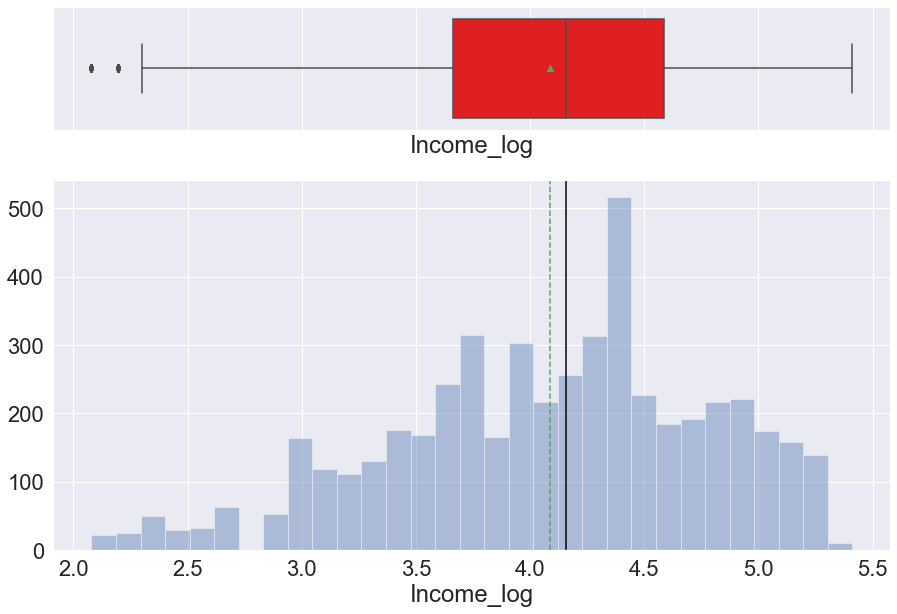

In [25]:
# apply log transformation
data['Income_log']= np.log(data["Income"])
histogram_boxplot(data.Income_log)

### Outlier treatment for Income

In [26]:
# common function for outlier treatment
def treat_outliers(df,col):
    '''
    treats outliers in a variable
    col: str, name of the numerical variable
    df: data frame
    col: name of the column
    '''
    Q1=df[col].quantile(0.25) # 25th quantile
    Q3=df[col].quantile(0.75)  # 75th quantile
    IQR=(Q3-Q1)
    Lower_Whisker = Q1 - 1.5*IQR 
    Upper_Whisker = Q3 + 1.5*IQR
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker) # all the values samller than Lower_Whisker will be assigned value of Lower_whisker 
                                                            # and all the values above upper_whishker will be assigned value of upper_Whisker 
    return df

In [27]:
data = treat_outliers(data, 'Income_log')

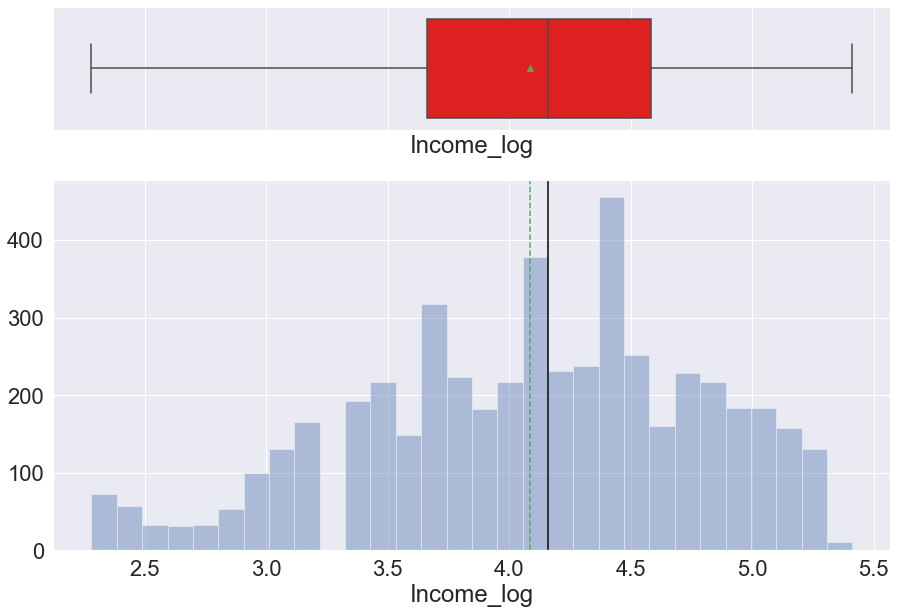

In [28]:
# boxplot and histogram for column Income after outlier treatment
histogram_boxplot(data.Income_log)

<AxesSubplot:xlabel='Family', ylabel='count'>

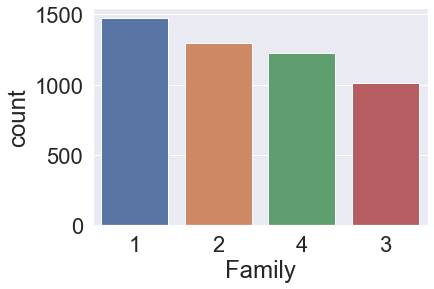

In [29]:
# count plot for column Family
sns.countplot(x="Family", data=data, order=data["Family"].value_counts().index[0:4])

#### Observation: 
- Singles and couples type customers are high in number. 

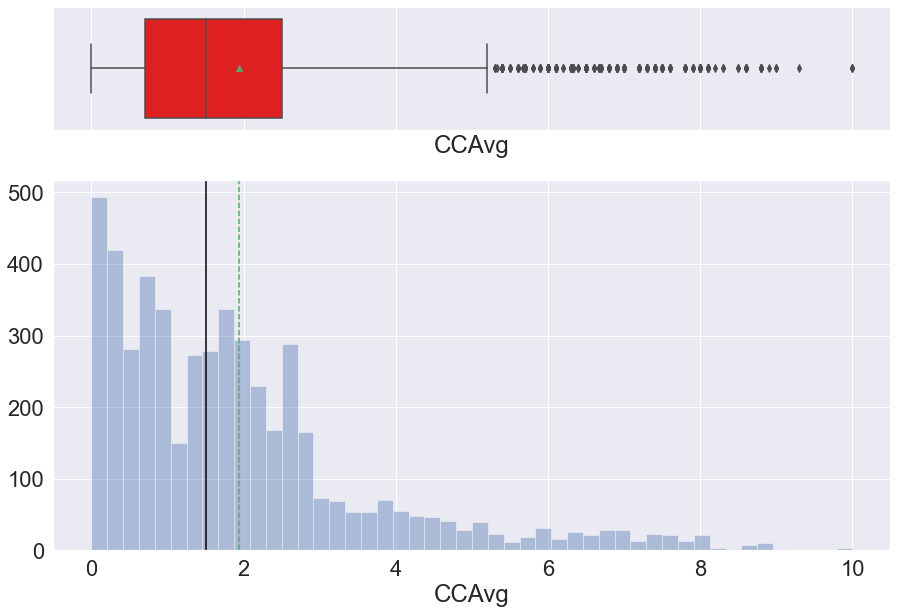

In [30]:
# boxplot and histogram for column CCAvg
histogram_boxplot(data.CCAvg)

#### Observation:
- Most of the customers are having credit card usage falling below 3k for month.
- And customers with CCAvg 0 are high (~500)
- There are some outliers and right skewed. we will need to have this treated for log transforamtion & outliers. 

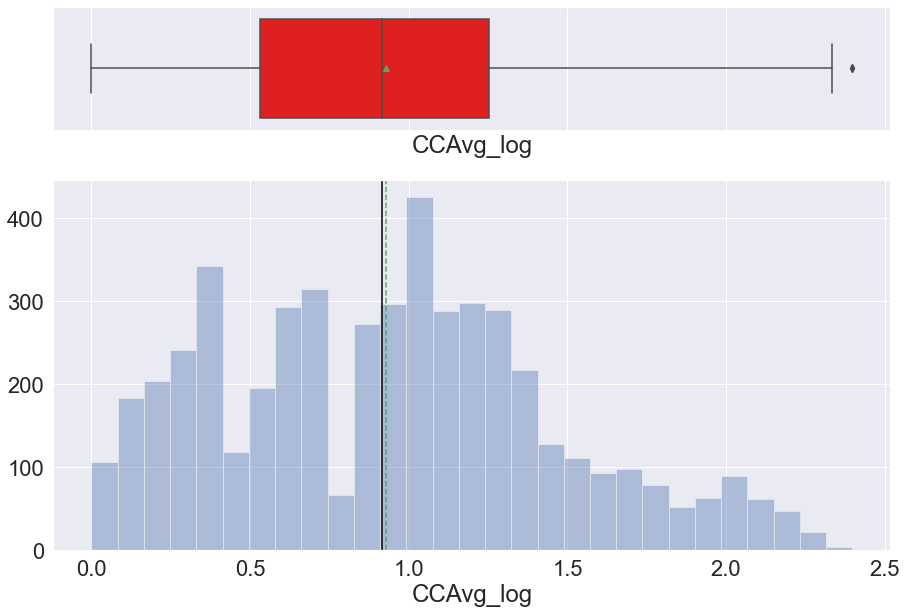

In [31]:
# applied log(n+1) to avoid OverflowError: cannot convert float infinity to integer
data['CCAvg_log']=np.log(data.CCAvg+1)
histogram_boxplot(data.CCAvg_log)

In [32]:
# outlier treatment for CCAvg
data = treat_outliers(data, 'CCAvg_log')

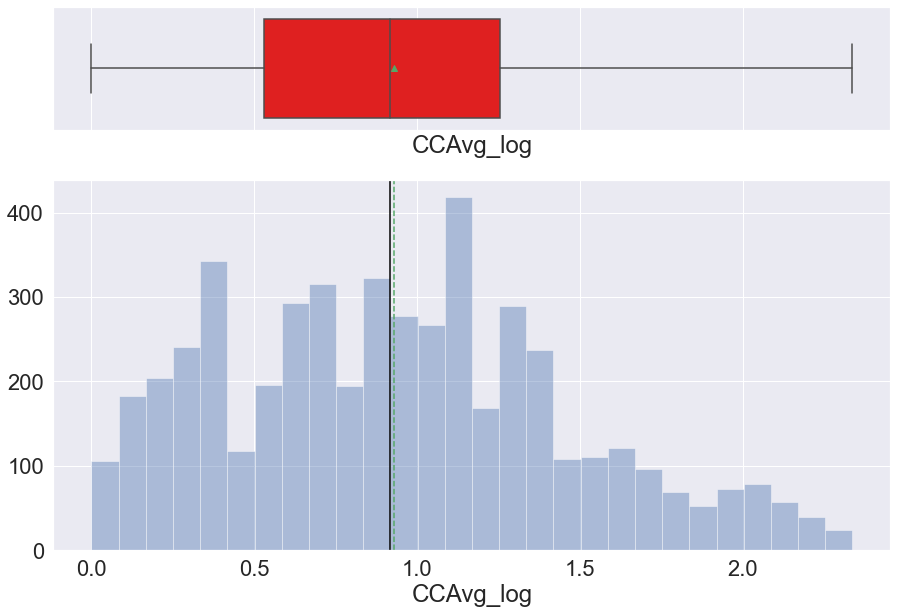

In [33]:
# boxplot and histogram for column CCAvg after outlier treatment
histogram_boxplot(data.CCAvg_log)

<AxesSubplot:xlabel='Education', ylabel='count'>

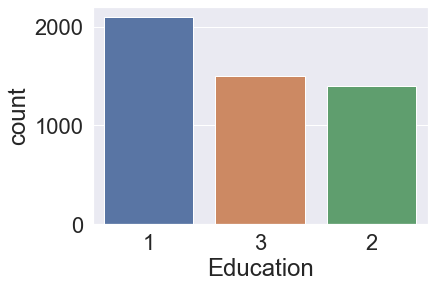

In [34]:
# count plot for column Education
sns.countplot(x="Education", data=data, order=data["Education"].value_counts().index[0:4])

#### Observation : 
- undergrad customers are high in number

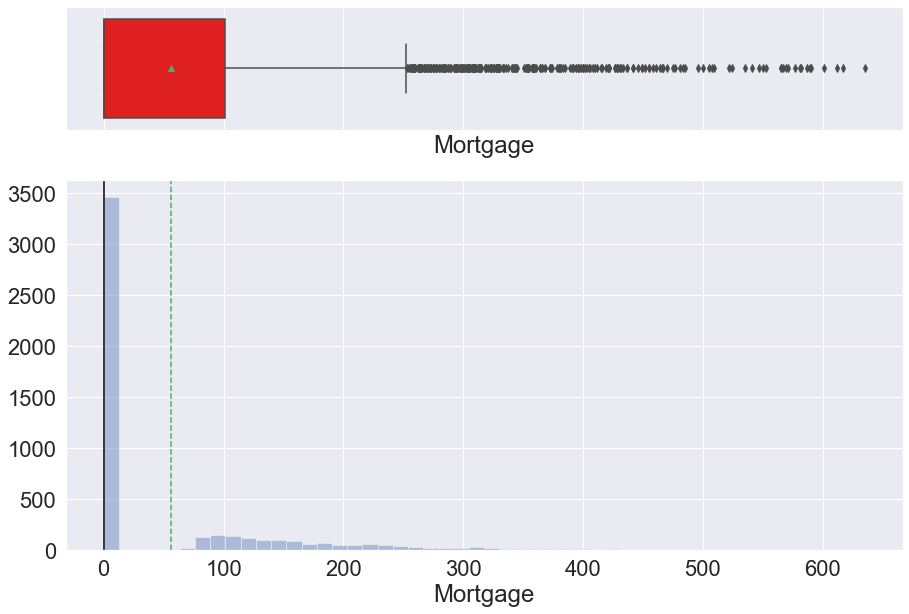

In [35]:
# boxplot and histogram for column Mortgage
histogram_boxplot(data.Mortgage)

#### Observation :
- Mortgage is highly righ skewed and more out liers .we might need to apply log transformation
- There are more number of customers with 0 mortgage.

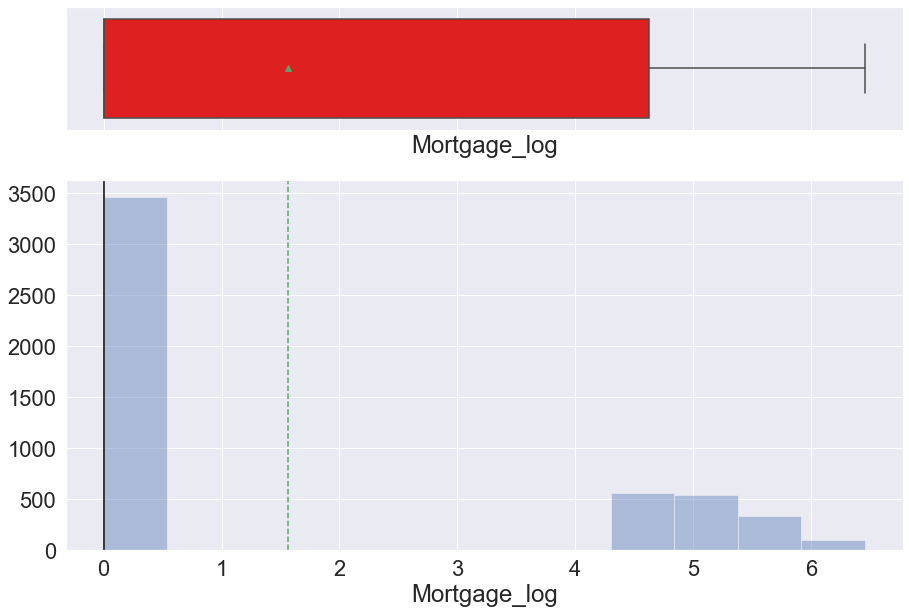

In [36]:
# apply log transfermation on Mortgage
data['Mortgage_log']=np.log(data.Mortgage+1)
histogram_boxplot(data.Mortgage_log)

<AxesSubplot:xlabel='Personal_Loan', ylabel='count'>

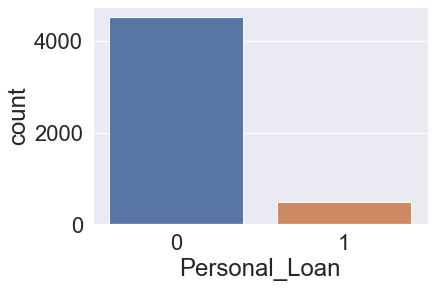

In [37]:
# count plot for column personal loan 
sns.countplot(x="Personal_Loan", data=data, order=data["Personal_Loan"].value_counts().index[0:2])

#### Observation : Very few number of people were offered personal loan

<AxesSubplot:xlabel='Securities_Account', ylabel='count'>

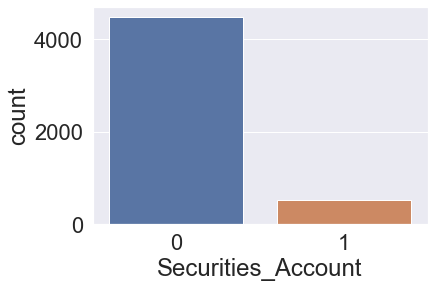

In [38]:
# count plot for column Securities_Account 
sns.countplot(x="Securities_Account", data=data, order=data["Securities_Account"].value_counts().index[0:2])

#### Observation : very less number of the people has securities account

<AxesSubplot:xlabel='CD_Account', ylabel='count'>

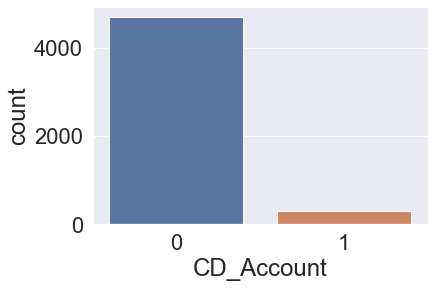

In [39]:
# count plot for column CD_Account 
sns.countplot(x="CD_Account", data=data, order=data["CD_Account"].value_counts().index[0:2])

##### Observation : very less number of the people has CD account

<AxesSubplot:xlabel='Online', ylabel='count'>

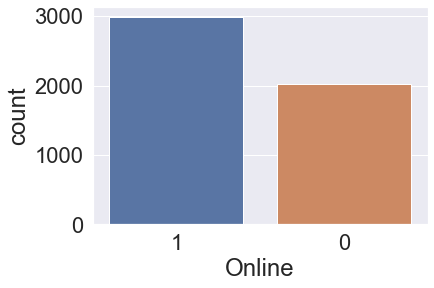

In [40]:
# count plot for column Online 
sns.countplot(x="Online", data=data, order=data["Online"].value_counts().index[0:2])

#### There are significant number of people who uses internet banking facilities

<AxesSubplot:xlabel='CreditCard', ylabel='count'>

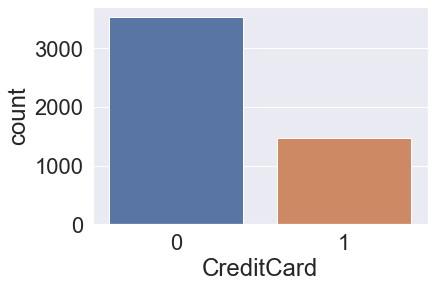

In [41]:
# count plot for column CreditCard 
sns.countplot(x="CreditCard", data=data, order=data["CreditCard"].value_counts().index[0:2])

#### Observation : 
- There are ~1400 customers who uses credit cards issued by other banks 
- There are ~3500 customers who doesnot have credit cards issued by other banks except AllLife


In [42]:
data.groupby(["county"])["city_name"].size().sort_values(ascending=False)

county
Los Angeles County        1095
San Diego County           568
Santa Clara County         563
Alameda County             500
Orange County              339
San Francisco County       257
San Mateo County           204
Sacramento County          184
Santa Barbara County       154
Yolo County                130
Monterey County            128
Ventura County             114
San Bernardino County      101
Contra Costa County         85
Santa Cruz County           68
Riverside County            56
Kern County                 54
Marin County                54
unknown                     34
San Luis Obispo County      33
Solano County               33
Humboldt County             32
Sonoma County               28
Fresno County               26
Placer County               24
Butte County                19
Shasta County               18
El Dorado County            17
Stanislaus County           15
San Benito County           14
San Joaquin County          13
Mendocino County             8
T

<AxesSubplot:xlabel='count', ylabel='county'>

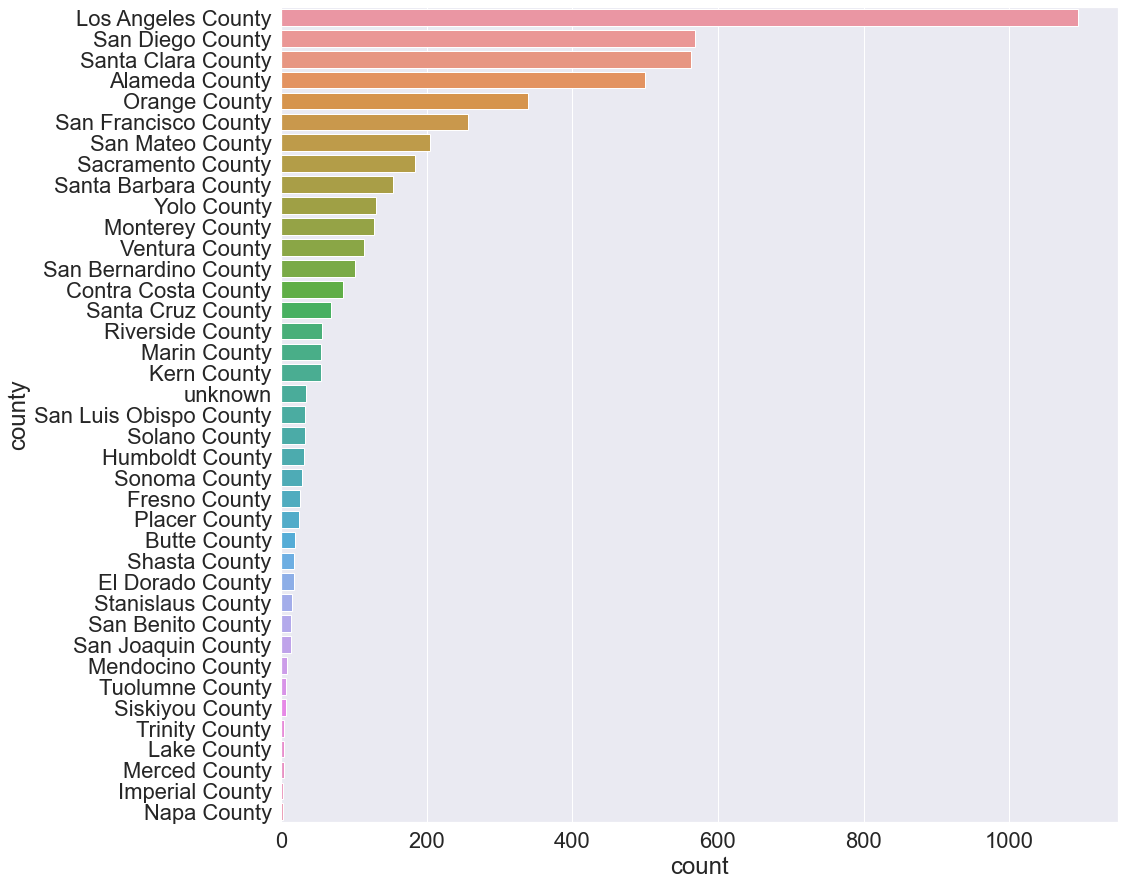

In [43]:
# count plot for column county
plt.figure(figsize=(15, 15))
sns.countplot(y="county", data=data, order=data["county"].value_counts(ascending=False).index[0:40])

#### Observation:
- All the customers are from california state.
- Below are the top counties which has more customer base.
  - Los Angeles County 
  - San Diego County
  - Santa Clara County
  - Alameda County
  - Orange County
  - San Francisco County
  - San Mateo County
- Following counties has lowest customer base.
  - Imperial County
  - Napa County
  - Merced County
  - Lake County
  - Trinity County

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 5000 non-null   int64   
 1   Experience          5000 non-null   int64   
 2   Income              5000 non-null   int64   
 3   ZIPCode             5000 non-null   int64   
 4   Family              5000 non-null   category
 5   CCAvg               5000 non-null   float64 
 6   Education           5000 non-null   category
 7   Mortgage            5000 non-null   int64   
 8   Personal_Loan       5000 non-null   int64   
 9   Securities_Account  5000 non-null   int64   
 10  CD_Account          5000 non-null   int64   
 11  Online              5000 non-null   int64   
 12  CreditCard          5000 non-null   int64   
 13  city_name           5000 non-null   object  
 14  county              5000 non-null   object  
 15  Income_log          5000 non-null   fl

# Bivariate Distributions 

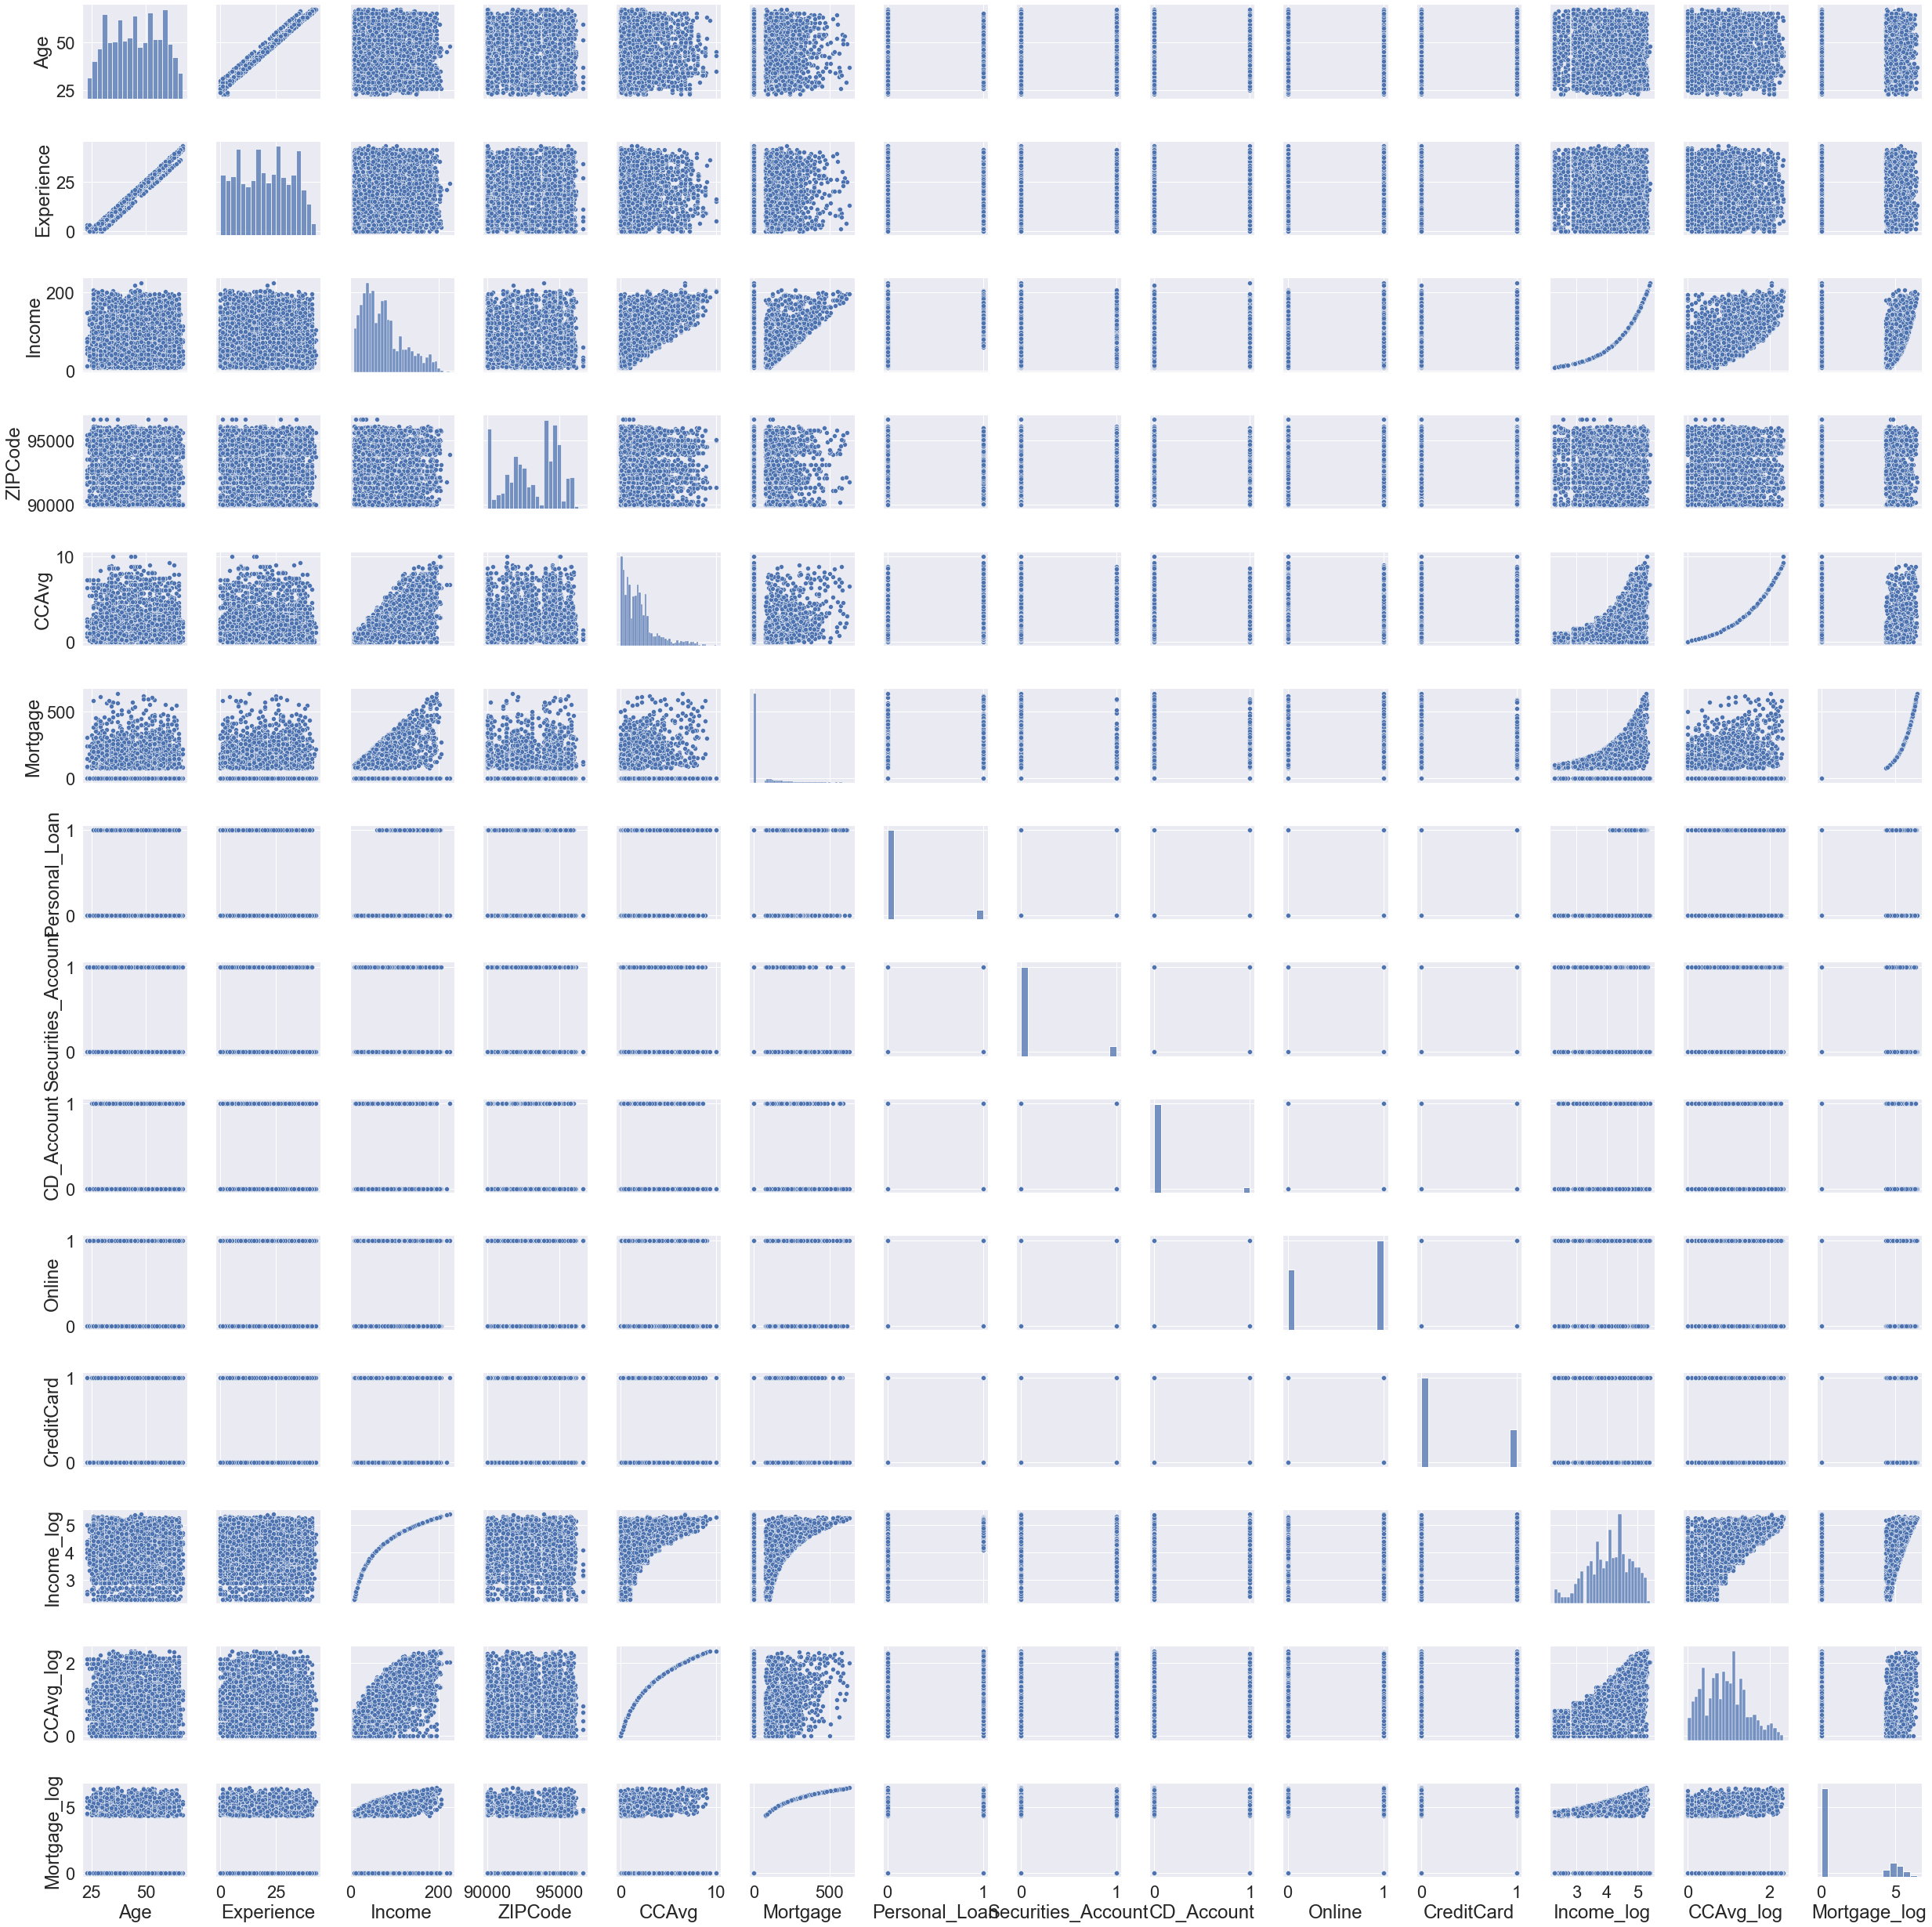

In [45]:
#pair plot
sns.pairplot(data)

##### Observation : 
- Age and Experience are possitivly correlated.
- Experience does not have much impact on Income, CCAvg, Mortgage(does not have relation ship)
- Income has possitive relations ship with CCAvg & Mortgage. Higher the income more CCAvg and Mortgage

### Correlation between numeric Variables

<AxesSubplot:>

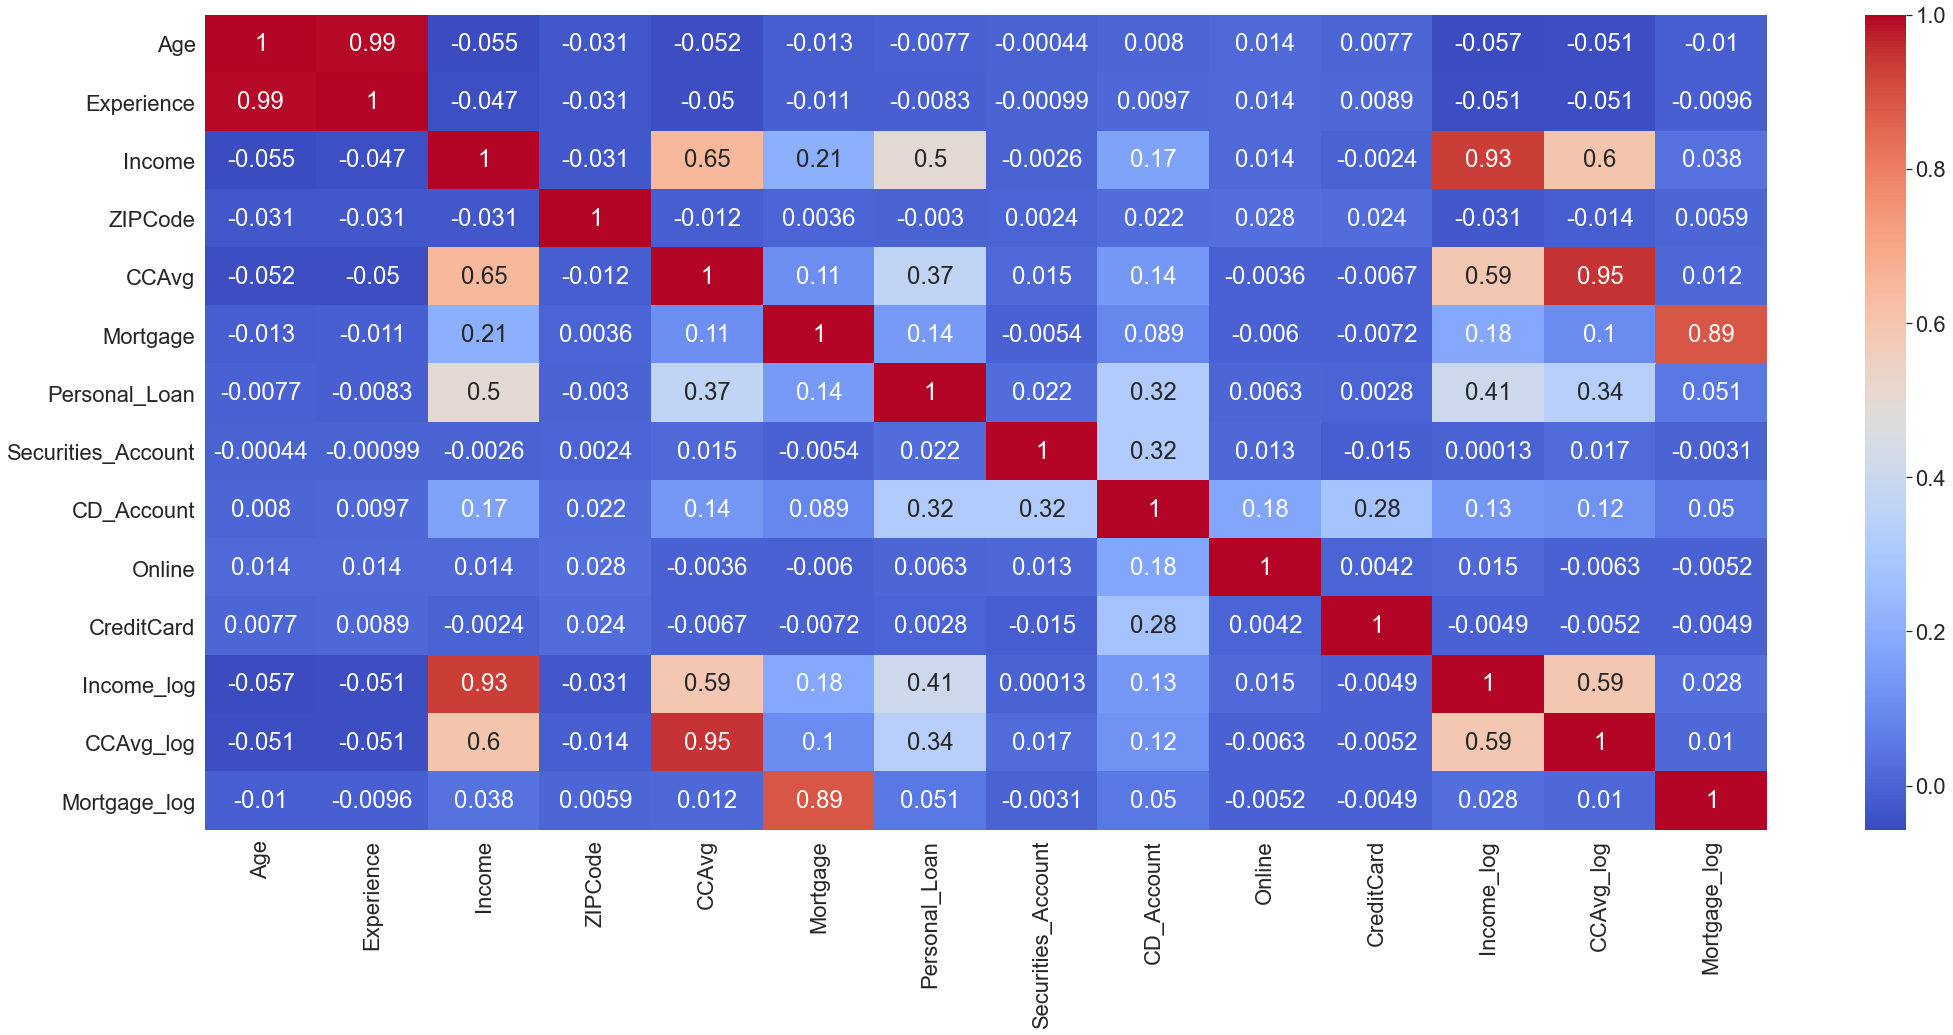

In [46]:
plt.figure(figsize=(35, 15))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")

##### Income, CCAvg, Mortgage, CD_Account are important predectors for Persnal loan. 
zipcode does not have any impact on Personal loan or any other variables hence droping Zipcodes, City Name, State, County 

In [47]:
# droping county,city_name,ZIPCode columns
data.drop(['county','city_name','ZIPCode'],axis=1,inplace=True)

<AxesSubplot:xlabel='Personal_Loan', ylabel='Income'>

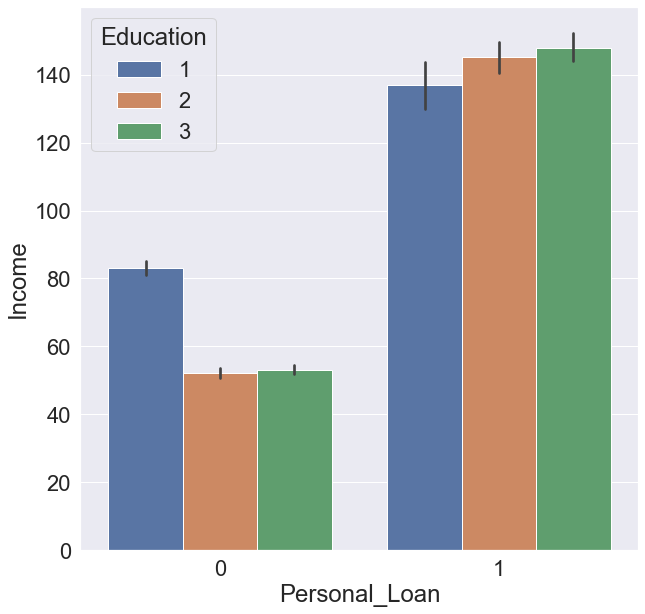

In [48]:
# personal loan vs Education vs Income
plt.figure(figsize=(10,10))
sns.barplot(x='Personal_Loan',y='Income', data=data, orient="v",hue='Education' )

#### More chances of approval of loan with higher income.

<AxesSubplot:xlabel='Education', ylabel='count'>

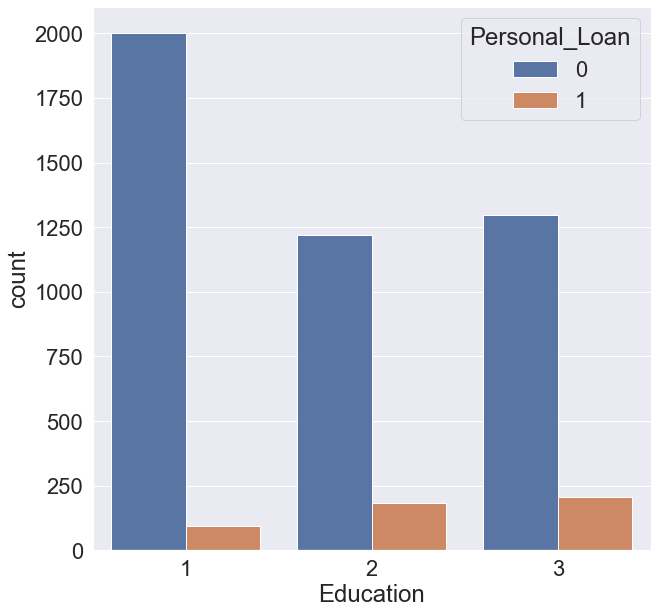

In [49]:
# Education vs Personal Loan
plt.figure(figsize=(10,10))
sns.countplot(data['Education'], hue = data['Personal_Loan'])

#### Most of the customers who has higer education 2 & 3 has good chances of loan approval

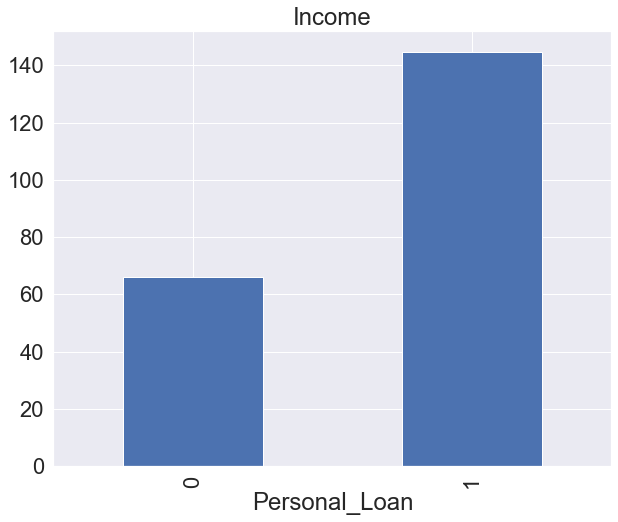

In [50]:
plt.figure(figsize=(10,8))
data.groupby('Personal_Loan')['Income'].mean().plot(kind='bar',title='Income');

* customers with higher income are offered loans.

In [51]:
# drop the redundent columns.['Mortgage','CCAvg','Income'],Also Zipcode which we already mapped with counties and city names
print('columns before droping ', data.columns)
data.drop(['Mortgage','CCAvg','Income'],axis=1, inplace=True)
print('columns after droping ', data.columns)

columns before droping  Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education',
       'Mortgage', 'Personal_Loan', 'Securities_Account', 'CD_Account',
       'Online', 'CreditCard', 'Income_log', 'CCAvg_log', 'Mortgage_log'],
      dtype='object')
columns after droping  Index(['Age', 'Experience', 'Family', 'Education', 'Personal_Loan',
       'Securities_Account', 'CD_Account', 'Online', 'CreditCard',
       'Income_log', 'CCAvg_log', 'Mortgage_log'],
      dtype='object')


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 5000 non-null   int64   
 1   Experience          5000 non-null   int64   
 2   Family              5000 non-null   category
 3   Education           5000 non-null   category
 4   Personal_Loan       5000 non-null   int64   
 5   Securities_Account  5000 non-null   int64   
 6   CD_Account          5000 non-null   int64   
 7   Online              5000 non-null   int64   
 8   CreditCard          5000 non-null   int64   
 9   Income_log          5000 non-null   float64 
 10  CCAvg_log           5000 non-null   float64 
 11  Mortgage_log        5000 non-null   float64 
dtypes: category(2), float64(3), int64(7)
memory usage: 400.8 KB


# Model building

#### Creating dummy variables & data split

In [53]:
data['Securities_Account']=data['Securities_Account'].astype('category')
data['CD_Account']=data['CD_Account'].astype('category')
data['Online']=data['Online'].astype('category')
data['CreditCard']=data['CreditCard'].astype('category')

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 5000 non-null   int64   
 1   Experience          5000 non-null   int64   
 2   Family              5000 non-null   category
 3   Education           5000 non-null   category
 4   Personal_Loan       5000 non-null   int64   
 5   Securities_Account  5000 non-null   category
 6   CD_Account          5000 non-null   category
 7   Online              5000 non-null   category
 8   CreditCard          5000 non-null   category
 9   Income_log          5000 non-null   float64 
 10  CCAvg_log           5000 non-null   float64 
 11  Mortgage_log        5000 non-null   float64 
dtypes: category(6), float64(3), int64(3)
memory usage: 264.5 KB


In [55]:
def encode_cat_vars(x):
    x = pd.get_dummies(
        x,
        columns=x.select_dtypes(include=["object", "category"]).columns.tolist(),
        drop_first=True,
    )
    return x
# X = data.drop(['Personal_Loan'], axis=1)
Y = data['Personal_Loan']
X = encode_cat_vars(data.drop(['Personal_Loan'], axis=1))
X.head()


Age  Experience  Income_log  CCAvg_log  Mortgage_log  Family_2  Family_3  \
0   25           1    3.891820   0.955511           0.0         0         0   
1   45          19    3.526361   0.916291           0.0         0         1   
2   39          15    2.397895   0.693147           0.0         0         0   
3   35           9    4.605170   1.308333           0.0         0         0   
4   35           8    3.806662   0.693147           0.0         0         0   

   Family_4  Education_2  Education_3  Securities_Account_1  CD_Account_1  \
0         1            0            0                     1             0   
1         0            0            0                     1             0   
2         0            0            0                     0             0   
3         0            1            0                     0             0   
4         1            1            0                     0             0   

   Online_1  CreditCard_1  
0         0             0  
1         0             0  
2         0             0  
3         0             0  
4         0             1

In [56]:
#Splitting data in train and test sets
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.30, random_state = 1)

#### create two functions to calculate different metrics and confusion matrix so that we don't have to use the same code repeatedly for each model.

In [57]:
# Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,train,test,train_y,test_y,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    
    score_list=[] 
    
    pred_train = model.predict(train)
    pred_test = model.predict(test)
    
    train_acc = accuracy_score(pred_train,train_y)
    test_acc = accuracy_score(pred_test,test_y)
    
    train_recall = recall_score(train_y,pred_train)
    test_recall = recall_score(test_y,pred_test)
    
    train_precision = precision_score(train_y,pred_train)
    test_precision = precision_score(test_y,pred_test)
    
    train_f1 = f1_score(train_y,pred_train)
    test_f1 = f1_score(test_y,pred_test)
    
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision,train_f1,test_f1))
        
     # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",accuracy_score(pred_train,train_y))
        print("Accuracy on test set : ",accuracy_score(pred_test,test_y))
        print("Recall on training set : ",recall_score(train_y,pred_train))
        print("Recall on test set : ",recall_score(test_y,pred_test))
        print("Precision on training set : ",precision_score(train_y,pred_train))
        print("Precision on test set : ",precision_score(test_y,pred_test))
        print("F1 on training set : ",f1_score(train_y,pred_train))
        print("F1 on test set : ",f1_score(test_y,pred_test))
    
    return score_list # returning the list with train and test scores

In [58]:
# function for getting confusion metrics
def make_confusion_matrix(model,test_X,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(test_X)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["actual Loan accpeted","actual Loan reject"]],
                  columns = [i for i in ['Predicted loan accept','Predicted loan reject']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Logistic Regression

Accuracy on training set :  0.9582857142857143
Accuracy on test set :  0.9493333333333334
Recall on training set :  0.6374622356495468
Recall on test set :  0.5637583892617449
Precision on training set :  0.890295358649789
Precision on test set :  0.8842105263157894
F1 on training set :  0.7429577464788734
F1 on test set :  0.6885245901639344


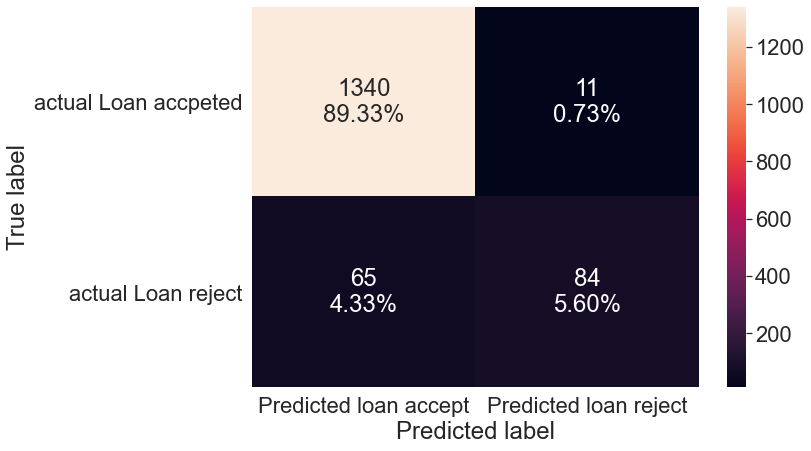

In [61]:
lg_model = LogisticRegression(solver="liblinear")
lg_model.fit(x_train, y_train)

y_predict = lg_model.predict(x_test)


coef_df = pd.DataFrame(lg_model.coef_)
coef_df['intercept'] = lg_model.intercept_

# creating confusion matrix
make_confusion_matrix(lg_model,x_test,y_test)

# checking model performance
scores_LR = get_metrics_score(lg_model,x_train,x_test,y_train,y_test,flag=True)

### ROC-AUC
- ROC-AUC on training set

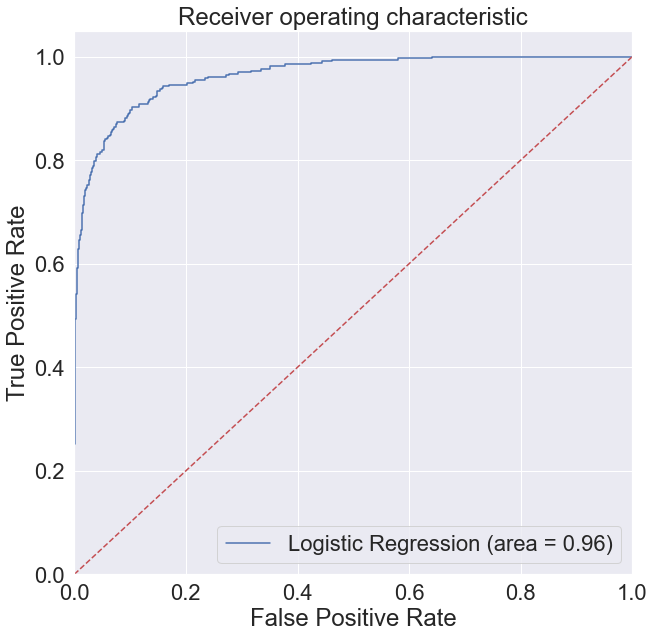

In [62]:
logit_roc_auc_train = roc_auc_score(y_train, lg_model.predict_proba(x_train)[:,1])
fpr, tpr, thresholds = roc_curve(y_train, lg_model.predict_proba(x_train)[:,1])
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_train)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

- ROC-AUC on testing set

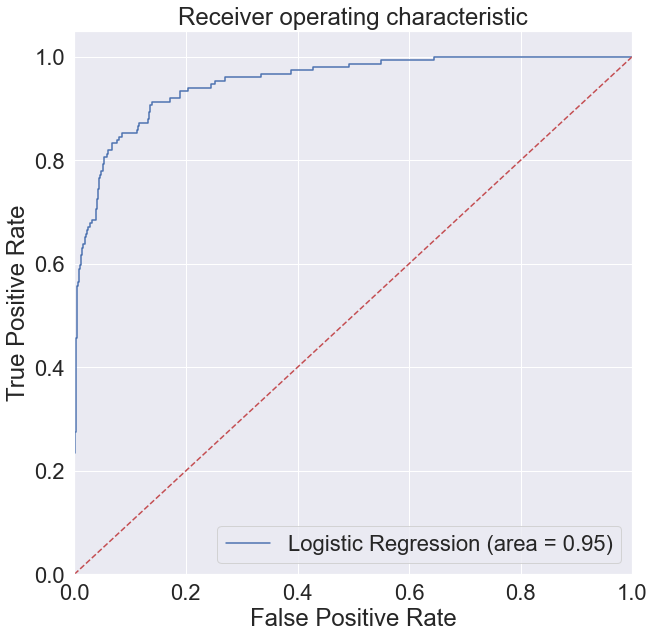

In [63]:
logit_roc_auc_test = roc_auc_score(y_test, lg_model.predict_proba(x_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, lg_model.predict_proba(x_test)[:,1])
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_test)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### finding coefficients

In [65]:
log_odds = lg_model.coef_[0]
pd.options.display.float_format = '{:.5f}'.format
pd.DataFrame(log_odds, x_train.columns, columns=['coef']).T

Age  Experience  Income_log  CCAvg_log  Mortgage_log  Family_2  \
coef -0.76549     0.76295     4.06596    1.31749       0.03955  -0.29758   

      Family_3  Family_4  Education_2  Education_3  Securities_Account_1  \
coef   1.62804   0.88251      2.62772      2.94468              -0.97153   

      CD_Account_1  Online_1  CreditCard_1  
coef       3.09139  -0.56197      -0.97090

#### Coefficient interpretations:
- Coefficient of Experience, Income, CCAvg, Mortgage, few levels of Family, few Eduction levels, CD_Acount  are positive, increase in these will lead to increase in chances of a person accepting personal Loan.
- Coefficient of Age, securities account, Mortgage, family level 1,CreditCard ,one of the education level & online are negative, Increase in thise will lead to decrease chances of accepting the personal loans. 

## Model Performance :

#### Let's see if the f1 score can be improved further, by changing the model threshold using AUC-ROC Curve.

#### Optimal threshold using AUC-ROC curve

In [66]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low
fpr, tpr, thresholds = metrics.roc_curve(y_test, lg_model.predict_proba(x_test)[:,1])

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(optimal_threshold)

0.08553982577383121


In [67]:
# Model prediction with optimal threshold

pred_train_opt = (lg_model.predict_proba(x_train)[:,1]>optimal_threshold)
pred_test_opt = (lg_model.predict_proba(x_test)[:,1]>optimal_threshold)

train_acc = accuracy_score(y_train, pred_train_opt)
test_acc  = accuracy_score(y_test, pred_test_opt)

print('Accuracy on train data:',train_acc)
print('Accuracy on test data:',test_acc)

train_rec = recall_score(y_train, pred_train_opt)
test_rec  = recall_score(y_test, pred_test_opt)

print('Recall on train data:',train_rec)
print('Recall on test data:',test_rec)

train_prec = precision_score(y_train, pred_train_opt)
test_prec  = precision_score(y_test, pred_test_opt)

print('Precision on train data:',train_prec)
print('Precision on test data:',test_prec)

train_f1 = f1_score(y_train, pred_train_opt)
test_f1  = f1_score(y_test, pred_test_opt)

print('F1 Score on train data:',train_f1)
print('F1 Score on test data:',test_f1)

train_roc = roc_auc_score(y_train, pred_train_opt)
test_roc  = roc_auc_score(y_test, pred_test_opt)

print('ROC-AUC Score on train data:',train_roc)
print('ROC-AUC Score on test data:',test_roc)

scores_optimal = []
scores_optimal.extend((train_acc,test_acc,train_rec,test_rec,train_prec,test_prec,train_f1,test_f1))

Accuracy on train data: 0.8617142857142858
Accuracy on test data: 0.866
Recall on train data: 0.9214501510574018
Recall on test data: 0.9060402684563759
Precision on train data: 0.399737876802097
Precision on test data: 0.4192546583850932
F1 Score on train data: 0.5575868372943328
F1 Score on test data: 0.5732484076433121
ROC-AUC Score on train data: 0.8884625321396191
ROC-AUC Score on test data: 0.8838121401497275


#### 
- F1 score and precession decreased compared to previous. but Recall increased drastically.
- Model performance did not increase. 

### Sequential Feature Selector

In [68]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# to plot the performance with addition of each feature
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [69]:
## Defining X and Y variables
Y = data['Personal_Loan']
X = encode_cat_vars(data.drop(['Personal_Loan'], axis=1))

#Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.30,random_state=1)

In [70]:
X_train.shape

(3500, 14)

In [71]:
# Fit the model on train
model = LogisticRegression(solver='newton-cg',n_jobs=-1,random_state=1,max_iter=100)

In [72]:
# we will first build model with all varaible
sfs = SFS(model, k_features=14, forward=True, floating=False, scoring='f1', verbose=2, cv=3,n_jobs=-1)

sfs = sfs.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    1.7s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    1.8s finished

[2021-05-28 23:50:25] Features: 1/14 -- score: 0.39002603821880927[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  13 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.2s finished

[2021-05-28 23:50:25] Features: 2/14 -- score: 0.5186879767725325[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.2s finished

[2021-05-28 23:50:25] Features: 3/14 -- score: 0.7641265837987149[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  1

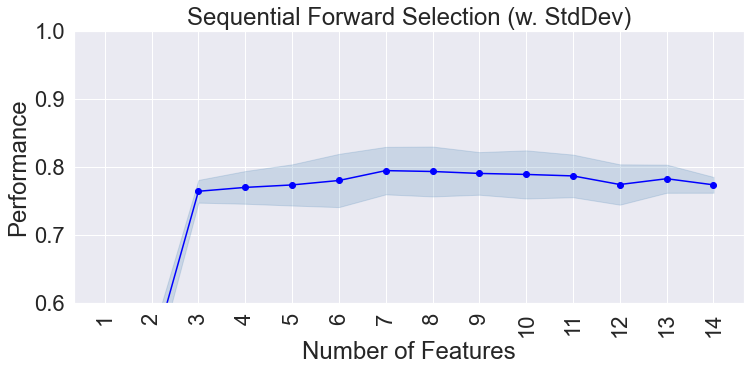

In [73]:
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev',figsize=(12,5))
plt.ylim([0.6, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.xticks(rotation=90)
plt.show()

* we can see that performance increased till 7th feature and then decreased.
* Model performance increased to 0.79 little compared to initial score 0.74 & score 0.55 using optimal threshold using AUC-ROC curve 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.1s finished

[2021-05-28 23:50:57] Features: 1/7 -- score: 0.39002603821880927[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  13 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.3s finished

[2021-05-28 23:50:57] Features: 2/7 -- score: 0.5186879767725325[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.2s finished

[2021-05-28 23:50:57] Features: 3/7 -- score: 0.7641265837987149[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 |

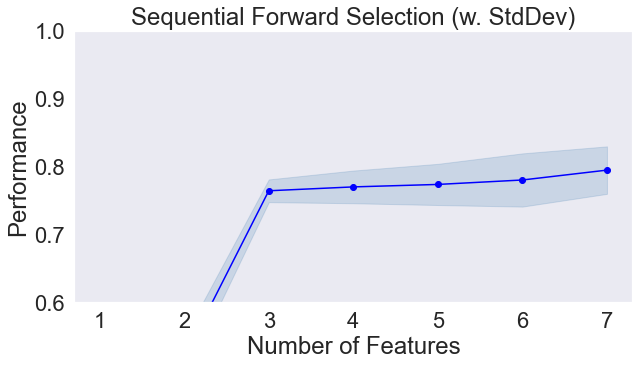

In [74]:
# lets use 7 features
sfs1 = SFS(model, k_features=7, forward=True, floating=False, scoring='f1', verbose=2, cv=3,n_jobs=-1)

sfs1 = sfs1.fit(X_train, y_train)

fig1 = plot_sfs(sfs1.get_metric_dict(),kind='std_dev',figsize=(10,5))

plt.ylim([0.6,1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [75]:
# Finding which features are important
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)
# get the column names
print(X_train.columns[feat_cols])

[2, 6, 8, 9, 10, 11, 13]
Index(['Income_log', 'Family_3', 'Education_2', 'Education_3',
       'Securities_Account_1', 'CD_Account_1', 'CreditCard_1'],
      dtype='object')


In [76]:
X_train_final = X_train[X_train.columns[feat_cols]]

#Creating new x_test with the same variables that we selected for x_train
X_test_final = X_test[X_train_final.columns]

In [77]:
#Fitting logistic regession model

logreg = LogisticRegression(solver='newton-cg',max_iter=1000,penalty='none',verbose=True,n_jobs=-1,random_state=0)

# There are several optimizer, we are using optimizer called as 'newton-cg' with max_iter equal to 10000 
# max_iter indicates number of iteration needed to converge

logreg.fit(X_train_final, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(max_iter=1000, n_jobs=-1, penalty='none', random_state=0,
                   solver='newton-cg', verbose=True)

### final Logistic model performance 

Accuracy on training set :  0.968
Accuracy on test set :  0.9593333333333334
Recall on training set :  0.7341389728096677
Recall on test set :  0.6375838926174496
Precision on training set :  0.9101123595505618
Precision on test set :  0.9313725490196079
F1 on training set :  0.8127090301003345
F1 on test set :  0.7569721115537849


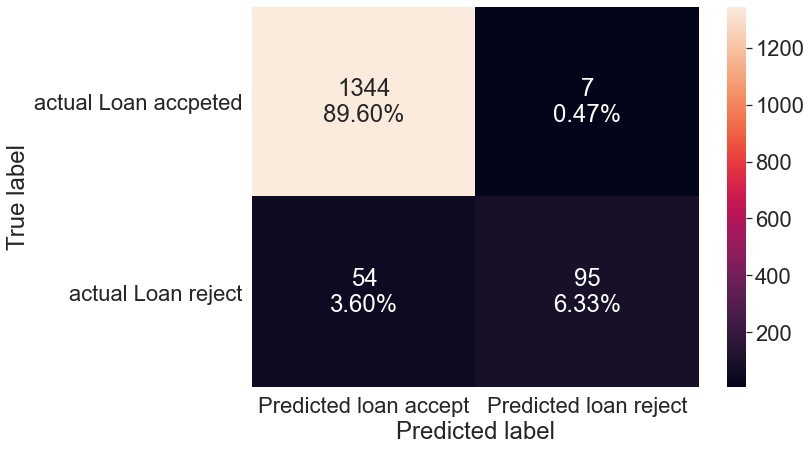

In [78]:
scores_LR = get_metrics_score(logreg,X_train_final,X_test_final,y_train,y_test,flag=True)

# creating confusion matrix
make_confusion_matrix(logreg,X_test_final,y_test)

## Conclusion on Logistic regression model building
- Able to build a predective model for customers who can accept personal loans with f1 score of 81 on training set.
- Following features Income_log', 'Family_3', 'Education_2', 'Education_3','Securities_Account_1', 'CD_Account_1', 'CreditCard_1 are significant for predecting Personal_Loan
- Coefficient of Experience, CCAvg, few lwvels of Family, few Eduction levels, securities account, CD_Acount, online, CreditCard are positive, increase in these will lead to increase in chances of a person accepting personal Loan.
- Coefficient of Age, income, Mortgage, few family levels, ,one of the education level are negative, Increase in thise will lead to decrease chances of accepting the personal loans. 

# Decision Tree model building

### Split Data

In [79]:
y = data['Personal_Loan']
X = encode_cat_vars(data.drop(['Personal_Loan'], axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=1)

### Build Decision tree 
- We will build our model using the DecisionTreeClassifier function. Using default 'gini' criteria to split. 

In [80]:
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1)
dTree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

### Scoring the tree

In [81]:
print("Accuracy on training set : ",dTree.score(X_train, y_train))
print("Accuracy on test set : ",dTree.score(X_test, y_test))

Accuracy on training set :  1.0
Accuracy on test set :  0.9826666666666667


In [82]:
#Checking number of positives
print(y.sum(axis = 0))

480


* The ratio of positives to negatives is almost 1:9, so if our model marks each sample as negative, then also we'll get 98% accuracy.
* Since the bank wants to expand the business does not want to loose the customer then we will use Precision as metric instead of Accuracy. Precision give the Actual Loans offered vs predected loan offered

### confusion metrics 

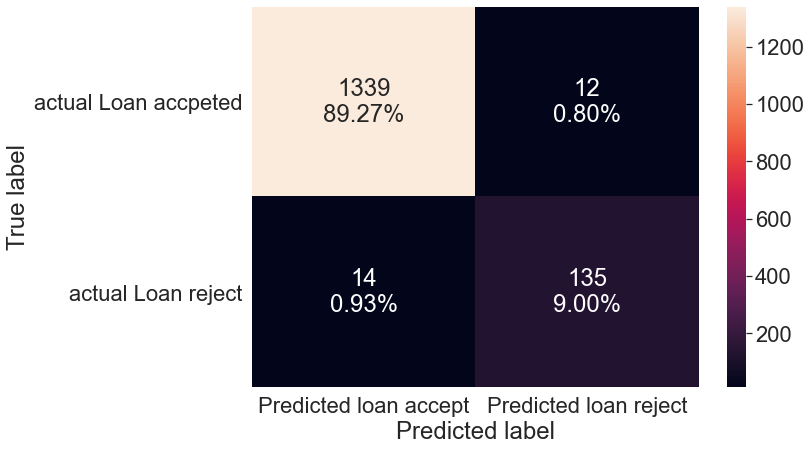

In [84]:
make_confusion_matrix(dTree,X_test,y_test)

In [85]:
##  Function to calculate Precision & recall score
def get_precession_recall_score(model):
    '''
    model : classifier to predict values of X

    '''
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
    print("Recall on test set : ",metrics.recall_score(y_test,pred_test))
    print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
    print("Precision on test set : ",metrics.precision_score(y_test,pred_test))

get_precession_recall_score(dTree)

Recall on training set :  1.0
Recall on test set :  0.9060402684563759
Precision on training set :  1.0
Precision on test set :  0.9183673469387755


### Visualizing the Decision Tree

In [86]:
feature_names = list(X.columns)
print(feature_names)

['Age', 'Experience', 'Income_log', 'CCAvg_log', 'Mortgage_log', 'Family_2', 'Family_3', 'Family_4', 'Education_2', 'Education_3', 'Securities_Account_1', 'CD_Account_1', 'Online_1', 'CreditCard_1']


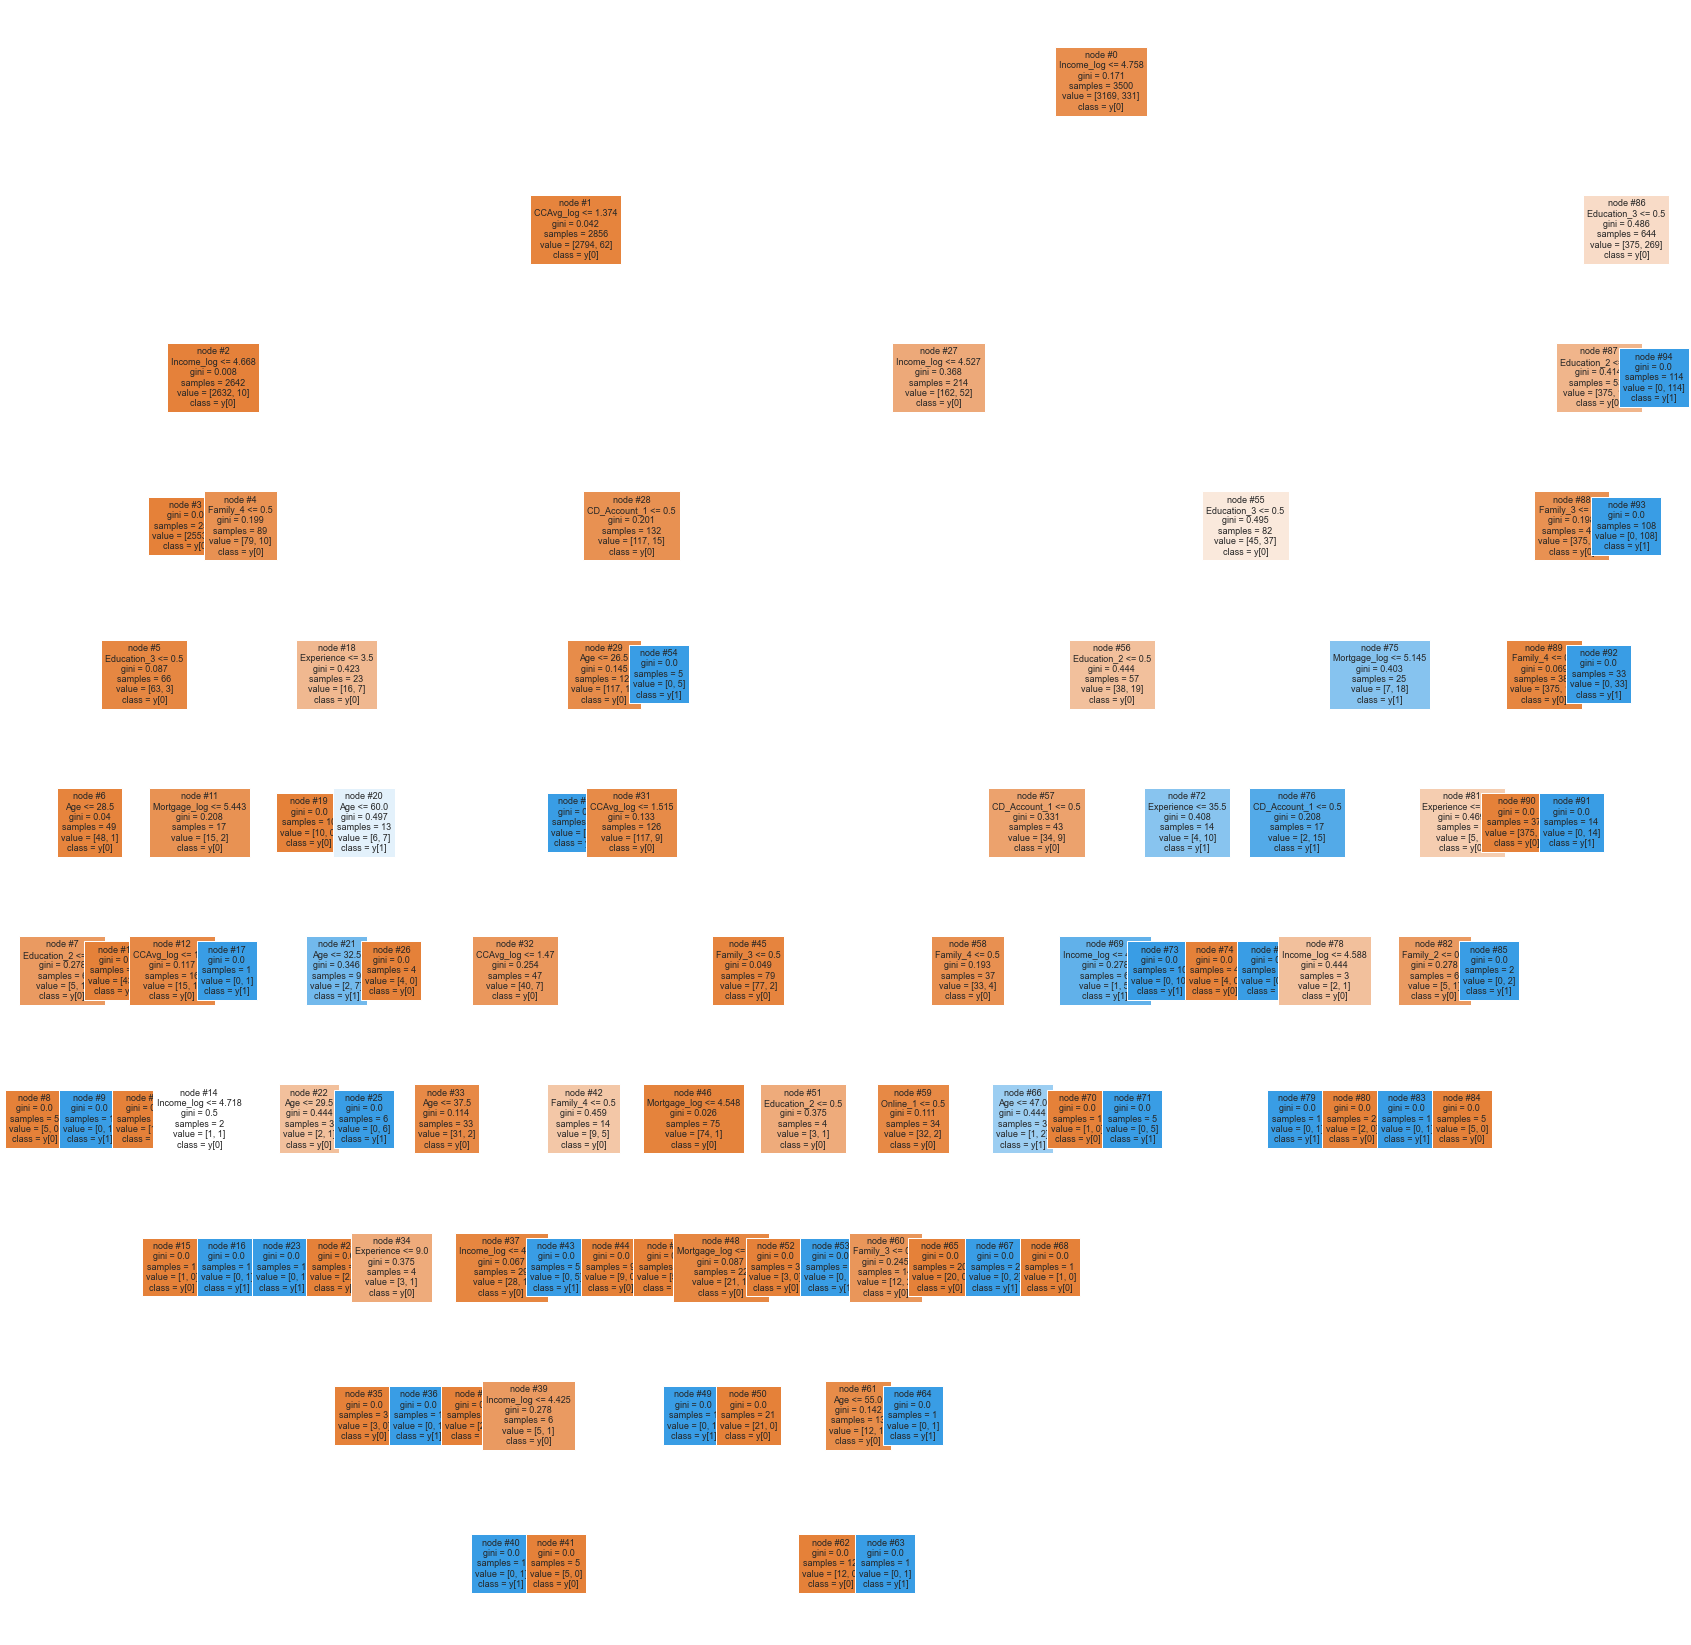

In [87]:
plt.figure(figsize=(30,30))
tree.plot_tree(dTree,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

In [88]:
# Text report showing the rules of a decision tree -

print(tree.export_text(dTree,feature_names=feature_names,show_weights=True))

|--- Income_log <= 4.76
|   |--- CCAvg_log <= 1.37
|   |   |--- Income_log <= 4.67
|   |   |   |--- weights: [2553.00, 0.00] class: 0
|   |   |--- Income_log >  4.67
|   |   |   |--- Family_4 <= 0.50
|   |   |   |   |--- Education_3 <= 0.50
|   |   |   |   |   |--- Age <= 28.50
|   |   |   |   |   |   |--- Education_2 <= 0.50
|   |   |   |   |   |   |   |--- weights: [5.00, 0.00] class: 0
|   |   |   |   |   |   |--- Education_2 >  0.50
|   |   |   |   |   |   |   |--- weights: [0.00, 1.00] class: 1
|   |   |   |   |   |--- Age >  28.50
|   |   |   |   |   |   |--- weights: [43.00, 0.00] class: 0
|   |   |   |   |--- Education_3 >  0.50
|   |   |   |   |   |--- Mortgage_log <= 5.44
|   |   |   |   |   |   |--- CCAvg_log <= 1.07
|   |   |   |   |   |   |   |--- weights: [14.00, 0.00] class: 0
|   |   |   |   |   |   |--- CCAvg_log >  1.07
|   |   |   |   |   |   |   |--- Income_log <= 4.72
|   |   |   |   |   |   |   |   |--- weights: [1.00, 0.00] class: 0
|   |   |   |   |   |   |   |-

In [89]:
# importance of features in the tree building.
print (pd.DataFrame(dTree.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                         Imp
Income_log           0.30771
Education_2          0.24085
Education_3          0.16579
Family_3             0.09768
Family_4             0.06297
CCAvg_log            0.04364
CD_Account_1         0.02635
Experience           0.02098
Age                  0.01997
Mortgage_log         0.01072
Family_2             0.00278
Online_1             0.00056
Securities_Account_1 0.00000
CreditCard_1         0.00000


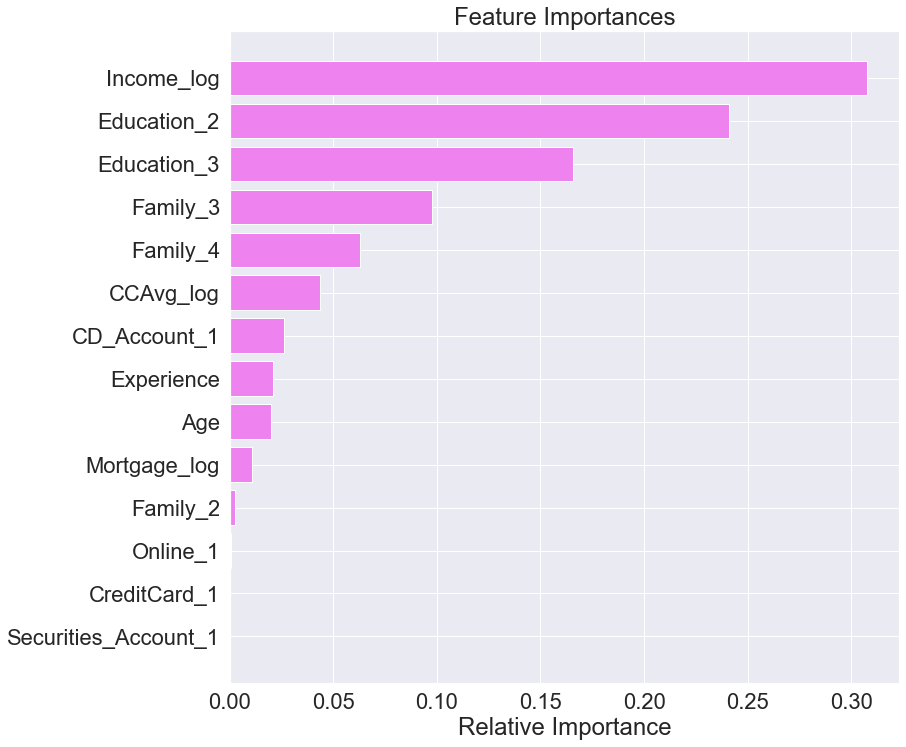

In [90]:
importances = dTree.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

* Acording to the decision tree Income is the most important feature

#### The Tree above is more complex. Reducing the complexity

In [91]:
# try limmiting the tree depth to 3
dTree1 = DecisionTreeClassifier(criterion = 'gini',max_depth=3,random_state=1)
dTree1.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=1)

### confusion metrics wit limited depth of the tree

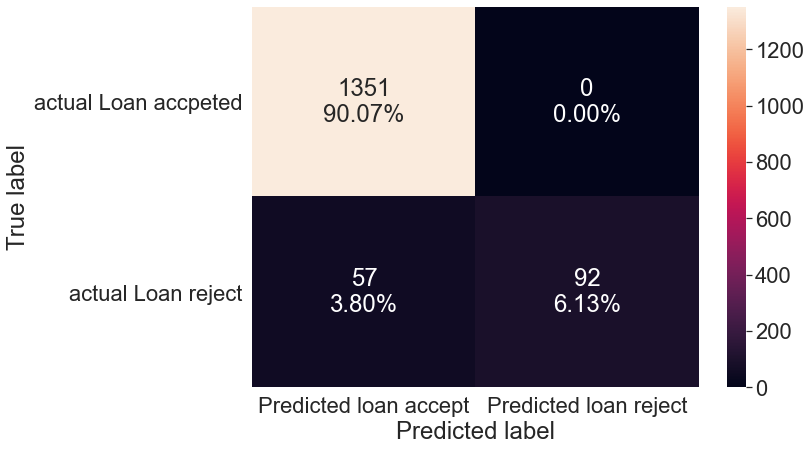

In [92]:
make_confusion_matrix(dTree1,X_test,y_test)

In [93]:
# Accuracy on train and test
print("Accuracy on training set : ",dTree1.score(X_train, y_train))
print("Accuracy on test set : ",dTree1.score(X_test, y_test))
# Precession on train and test
get_precession_recall_score(dTree1)

Accuracy on training set :  0.9688571428571429
Accuracy on test set :  0.962
Recall on training set :  0.6706948640483383
Recall on test set :  0.6174496644295302
Precision on training set :  1.0
Precision on test set :  1.0


* precesion on test set increased from 0.91 to 1.0 which is little improvement.

### Visualizing the Decision tree.

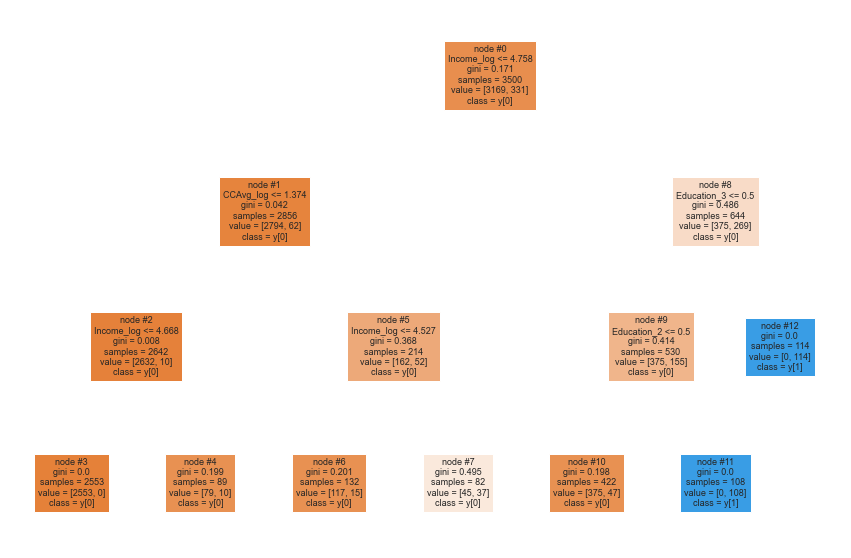

In [94]:
plt.figure(figsize=(15,10))

tree.plot_tree(dTree1,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

In [95]:
# Text report showing the rules of a decision tree -

print(tree.export_text(dTree1,feature_names=feature_names,show_weights=True))

|--- Income_log <= 4.76
|   |--- CCAvg_log <= 1.37
|   |   |--- Income_log <= 4.67
|   |   |   |--- weights: [2553.00, 0.00] class: 0
|   |   |--- Income_log >  4.67
|   |   |   |--- weights: [79.00, 10.00] class: 0
|   |--- CCAvg_log >  1.37
|   |   |--- Income_log <= 4.53
|   |   |   |--- weights: [117.00, 15.00] class: 0
|   |   |--- Income_log >  4.53
|   |   |   |--- weights: [45.00, 37.00] class: 0
|--- Income_log >  4.76
|   |--- Education_3 <= 0.50
|   |   |--- Education_2 <= 0.50
|   |   |   |--- weights: [375.00, 47.00] class: 0
|   |   |--- Education_2 >  0.50
|   |   |   |--- weights: [0.00, 108.00] class: 1
|   |--- Education_3 >  0.50
|   |   |--- weights: [0.00, 114.00] class: 1



* The tree became litte readable now.

In [96]:
# Check the importance of features in the tree building 

print (pd.DataFrame(dTree1.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                         Imp
Income_log           0.41426
Education_2          0.31517
Education_3          0.21800
CCAvg_log            0.05257
Age                  0.00000
Experience           0.00000
Mortgage_log         0.00000
Family_2             0.00000
Family_3             0.00000
Family_4             0.00000
Securities_Account_1 0.00000
CD_Account_1         0.00000
Online_1             0.00000
CreditCard_1         0.00000


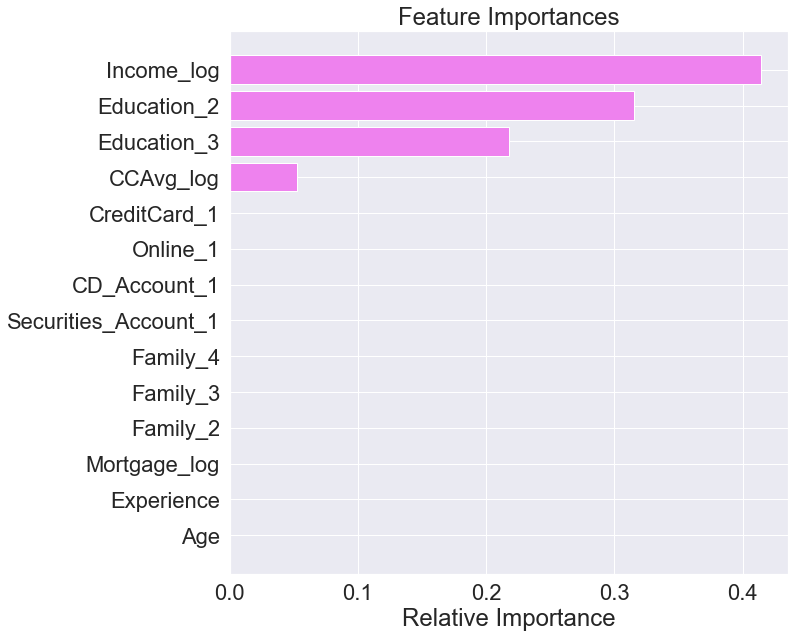

In [97]:
importances = dTree1.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

* before pre-pruning we can still see the importance of the feature Income is high. But other features like Family, CD account are zero.

### Using Gridsearch for finiding right hyperparameters for tuning the model

In [98]:
# Choose the type of classifier. 
estimator = DecisionTreeClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {'max_depth': np.arange(1,10), 
              'min_samples_leaf': [1, 2, 5, 7, 10,15,20],
              'max_leaf_nodes' : [2, 3, 5, 10],
              'min_impurity_decrease': [0.001,0.01,0.1]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
estimator.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10,
                       min_impurity_decrease=0.001, min_samples_leaf=5,
                       random_state=1)

### Confusion metrics - Decision tree with tuned hyperparameters

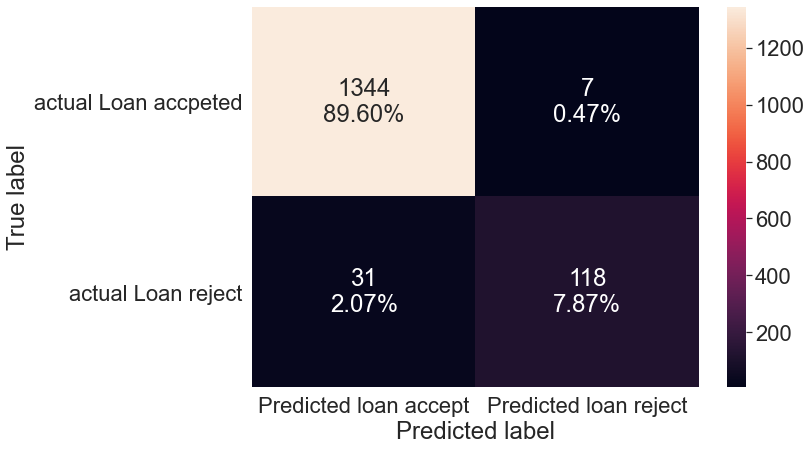

In [99]:
make_confusion_matrix(estimator,X_test,y_test)

In [100]:
# Accuracy on train and test
print("Accuracy on training set : ",estimator.score(X_train, y_train))
print("Accuracy on test set : ",estimator.score(X_test, y_test))
# Recall & precision train and test
get_precession_recall_score(estimator)

Accuracy on training set :  0.9868571428571429
Accuracy on test set :  0.9746666666666667
Recall on training set :  0.8821752265861027
Recall on test set :  0.7919463087248322
Precision on training set :  0.9765886287625418
Precision on test set :  0.944


* Precision has not much changed. But the recall has significantly increased from 67 to 88 after hyperparameter tuning.

### Visualizing the tree after hyper parameter tuning

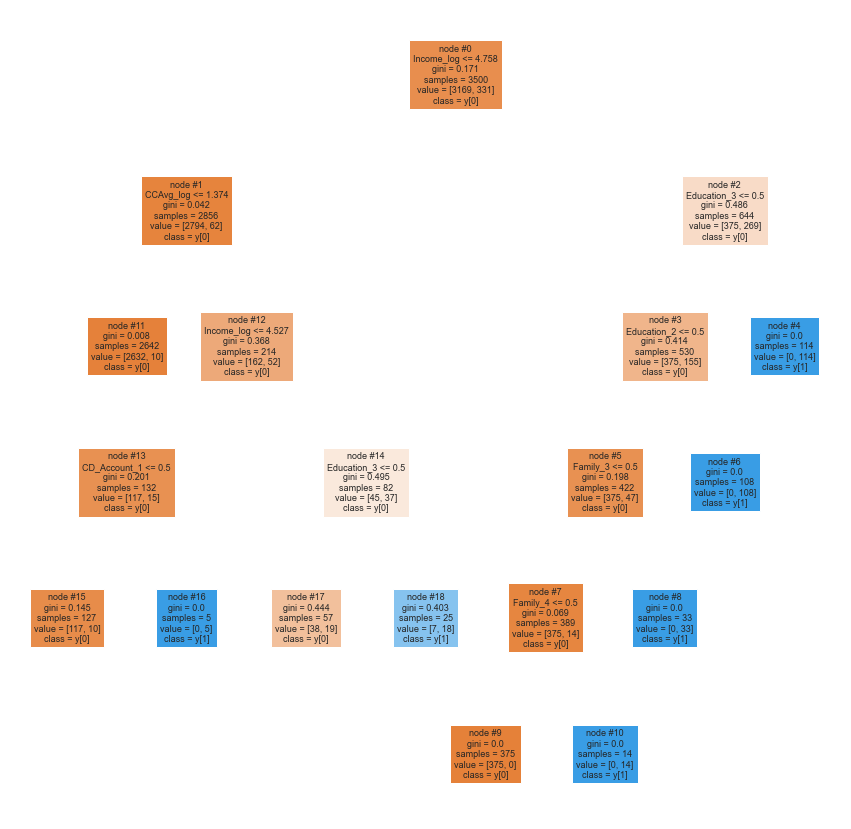

In [101]:
plt.figure(figsize=(15,15))

tree.plot_tree(estimator,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

In [102]:
#Text report showing the rules of a decision tree -

print(tree.export_text(estimator,feature_names=feature_names,show_weights=True))

|--- Income_log <= 4.76
|   |--- CCAvg_log <= 1.37
|   |   |--- weights: [2632.00, 10.00] class: 0
|   |--- CCAvg_log >  1.37
|   |   |--- Income_log <= 4.53
|   |   |   |--- CD_Account_1 <= 0.50
|   |   |   |   |--- weights: [117.00, 10.00] class: 0
|   |   |   |--- CD_Account_1 >  0.50
|   |   |   |   |--- weights: [0.00, 5.00] class: 1
|   |   |--- Income_log >  4.53
|   |   |   |--- Education_3 <= 0.50
|   |   |   |   |--- weights: [38.00, 19.00] class: 0
|   |   |   |--- Education_3 >  0.50
|   |   |   |   |--- weights: [7.00, 18.00] class: 1
|--- Income_log >  4.76
|   |--- Education_3 <= 0.50
|   |   |--- Education_2 <= 0.50
|   |   |   |--- Family_3 <= 0.50
|   |   |   |   |--- Family_4 <= 0.50
|   |   |   |   |   |--- weights: [375.00, 0.00] class: 0
|   |   |   |   |--- Family_4 >  0.50
|   |   |   |   |   |--- weights: [0.00, 14.00] class: 1
|   |   |   |--- Family_3 >  0.50
|   |   |   |   |--- weights: [0.00, 33.00] class: 1
|   |   |--- Education_2 >  0.50
|   |   |   |--

In [103]:
# importance of the features after hyper parameter tuning.
print (pd.DataFrame(estimator.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))


                         Imp
Income_log           0.33548
Education_2          0.25837
Education_3          0.18860
Family_3             0.10756
Family_4             0.05135
CCAvg_log            0.04310
CD_Account_1         0.01554
Age                  0.00000
Experience           0.00000
Mortgage_log         0.00000
Family_2             0.00000
Securities_Account_1 0.00000
Online_1             0.00000
CreditCard_1         0.00000


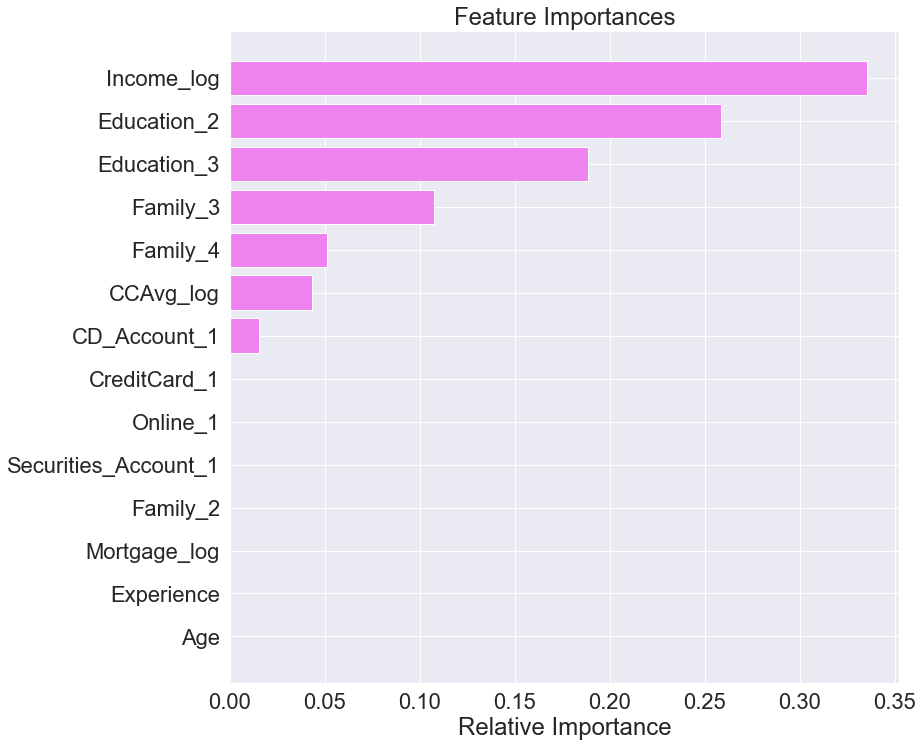

In [104]:
importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

* Importance of the features increased after hyperparameter tuning. Importance of Family , CD_accoiunt is back. Hence Hyperparameter tuning with gridsearchCV is helping better tree.

### Cost Complexity Pruning (post pruning)

In [105]:
clf = DecisionTreeClassifier(random_state=1)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [106]:
pd.DataFrame(path)

ccp_alphas  impurities
0      0.00000     0.00000
1      0.00027     0.00054
2      0.00027     0.00161
3      0.00028     0.00271
4      0.00028     0.00382
5      0.00036     0.00490
6      0.00038     0.00528
7      0.00038     0.00566
8      0.00038     0.00604
9      0.00048     0.00652
10     0.00048     0.00699
11     0.00051     0.00750
12     0.00058     0.00808
13     0.00060     0.00868
14     0.00063     0.00931
15     0.00077     0.01238
16     0.00079     0.01555
17     0.00080     0.01635
18     0.00155     0.01790
19     0.00155     0.02256
20     0.00233     0.02489
21     0.00329     0.02819
22     0.00647     0.03466
23     0.00771     0.04237
24     0.01615     0.05853
25     0.03282     0.12417
26     0.04709     0.17126

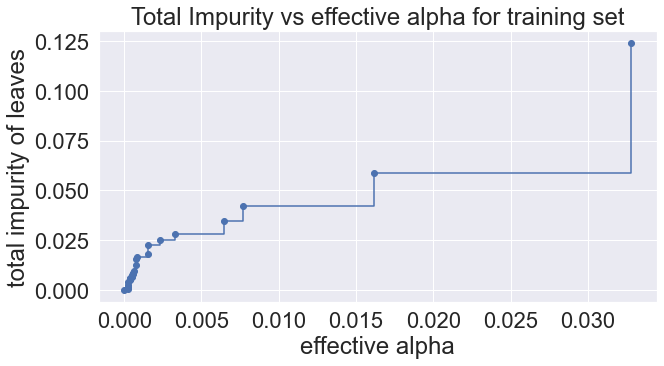

In [107]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [108]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.04708834100596768


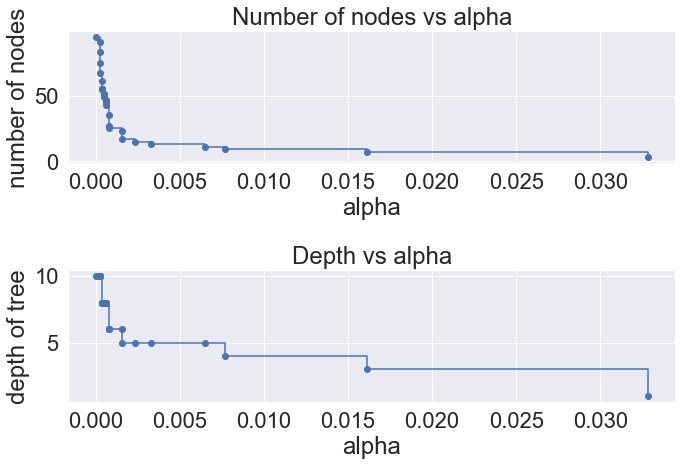

In [109]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1,figsize=(10,7))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

### Accuracy vs alpha for training and testing sets

In [110]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

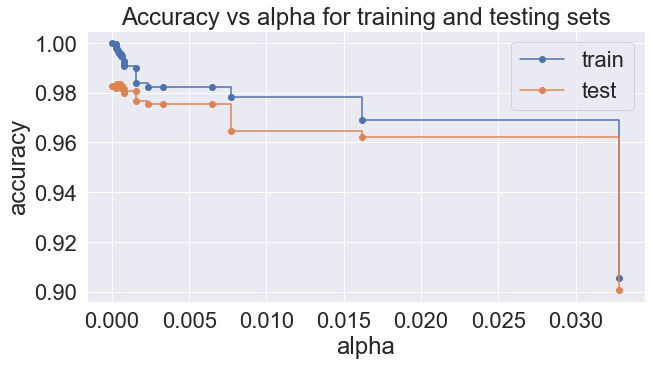

In [111]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [112]:
index_best_model = np.argmax(test_scores)
best_model = clfs[index_best_model]
print(best_model)
print('Training accuracy of best model: ',best_model.score(X_train, y_train))
print('Test accuracy of best model: ',best_model.score(X_test, y_test))

DecisionTreeClassifier(ccp_alpha=0.00035854341736694684, random_state=1)
Training accuracy of best model:  0.9974285714285714
Test accuracy of best model:  0.9833333333333333


* Since Accuracy is not the right metric we will go with Precision

In [113]:
precision_train=[]
for clf in clfs:
    pred_train3=clf.predict(X_train)
    values_train=metrics.precision_score(y_train,pred_train3)
    precision_train.append(values_train)

In [114]:
precision_test=[]
for clf in clfs:
    pred_test3=clf.predict(X_test)
    values_train=metrics.precision_score(y_test,pred_test3)
    precision_test.append(values_train)

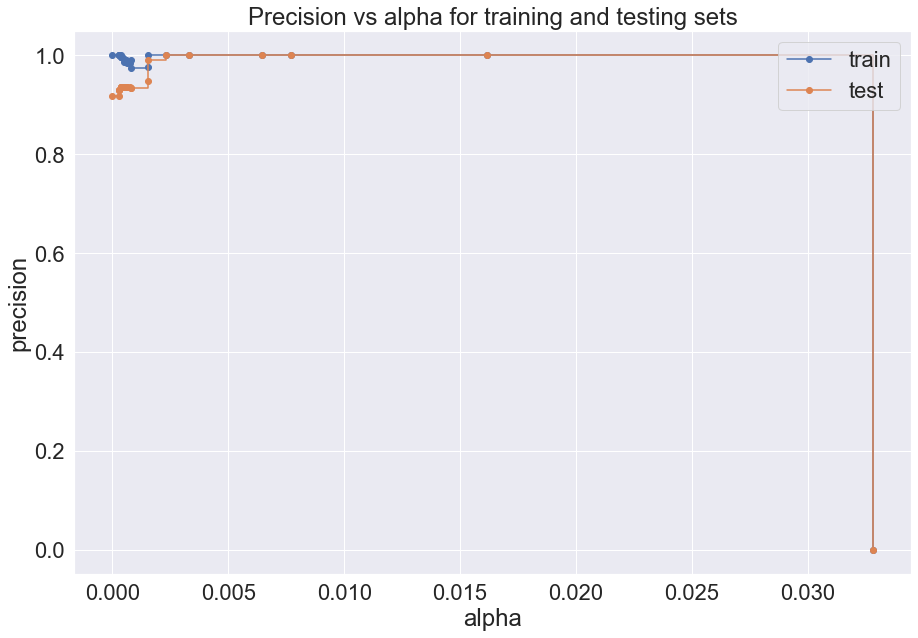

In [115]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlabel("alpha")
ax.set_ylabel("precision")
ax.set_title("Precision vs alpha for training and testing sets")
ax.plot(ccp_alphas, precision_train, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, precision_test, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [116]:
# creating the model where we get highest train and test recall
index_best_model = np.argmax(precision_test)
best_model = clfs[index_best_model]
print(best_model)

DecisionTreeClassifier(ccp_alpha=0.002333060640147255, random_state=1)


### cinfusion metrics 

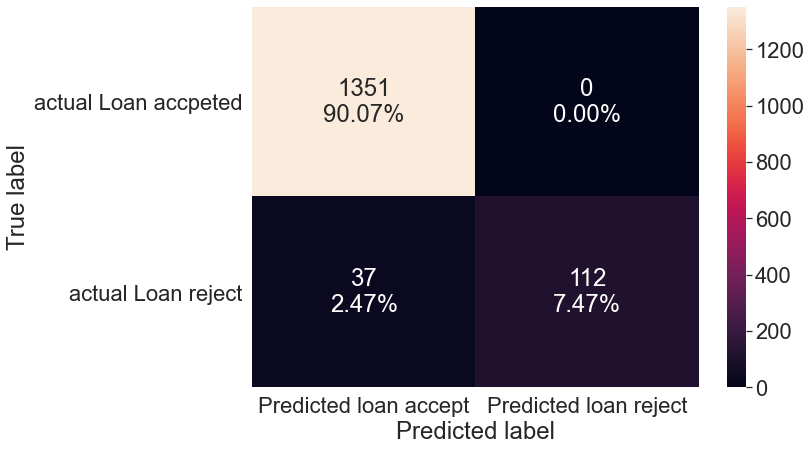

In [117]:
make_confusion_matrix(best_model,X_test,y_test)

In [118]:
# get precision & recall score:
get_precession_recall_score(best_model)

Recall on training set :  0.8126888217522659
Recall on test set :  0.7516778523489933
Precision on training set :  1.0
Precision on test set :  1.0


* with post pruning we get the highest precision as 1 

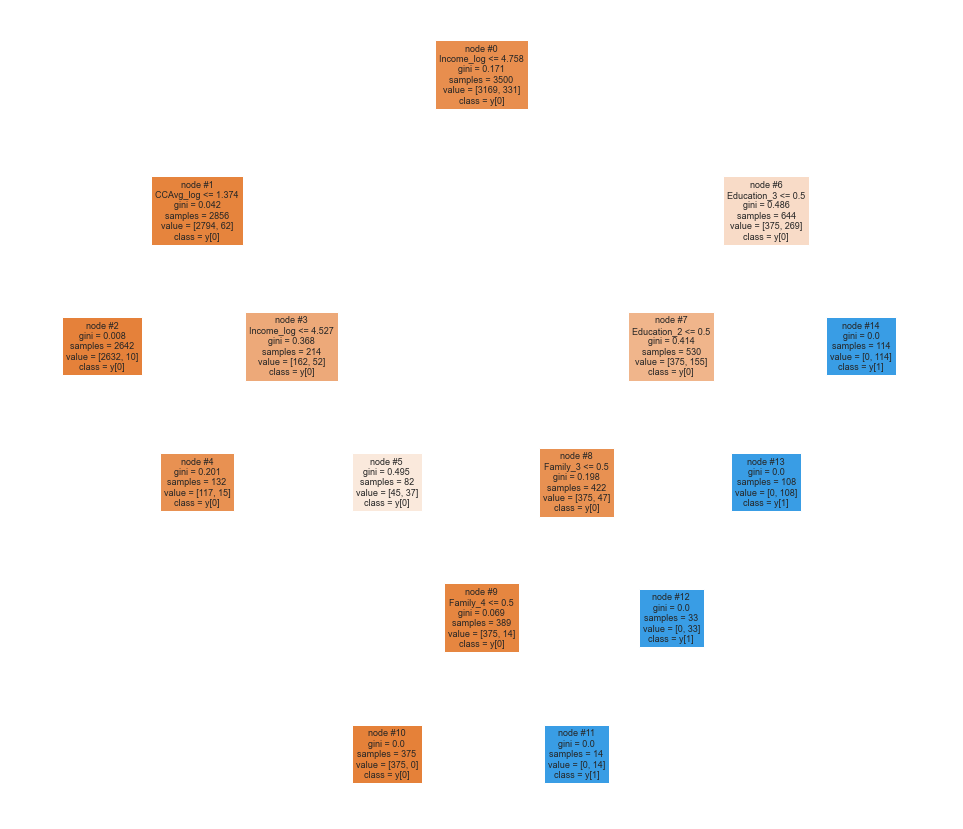

In [119]:
plt.figure(figsize=(17,15))

tree.plot_tree(best_model,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

In [120]:
# Text report showing the rules of a decision tree -

print(tree.export_text(best_model,feature_names=feature_names,show_weights=True))

|--- Income_log <= 4.76
|   |--- CCAvg_log <= 1.37
|   |   |--- weights: [2632.00, 10.00] class: 0
|   |--- CCAvg_log >  1.37
|   |   |--- Income_log <= 4.53
|   |   |   |--- weights: [117.00, 15.00] class: 0
|   |   |--- Income_log >  4.53
|   |   |   |--- weights: [45.00, 37.00] class: 0
|--- Income_log >  4.76
|   |--- Education_3 <= 0.50
|   |   |--- Education_2 <= 0.50
|   |   |   |--- Family_3 <= 0.50
|   |   |   |   |--- Family_4 <= 0.50
|   |   |   |   |   |--- weights: [375.00, 0.00] class: 0
|   |   |   |   |--- Family_4 >  0.50
|   |   |   |   |   |--- weights: [0.00, 14.00] class: 1
|   |   |   |--- Family_3 >  0.50
|   |   |   |   |--- weights: [0.00, 33.00] class: 1
|   |   |--- Education_2 >  0.50
|   |   |   |--- weights: [0.00, 108.00] class: 1
|   |--- Education_3 >  0.50
|   |   |--- weights: [0.00, 114.00] class: 1



In [121]:
# importance of features
print (pd.DataFrame(best_model.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                         Imp
Income_log           0.34423
Education_2          0.26511
Education_3          0.18337
Family_3             0.11037
Family_4             0.05269
CCAvg_log            0.04422
Age                  0.00000
Experience           0.00000
Mortgage_log         0.00000
Family_2             0.00000
Securities_Account_1 0.00000
CD_Account_1         0.00000
Online_1             0.00000
CreditCard_1         0.00000


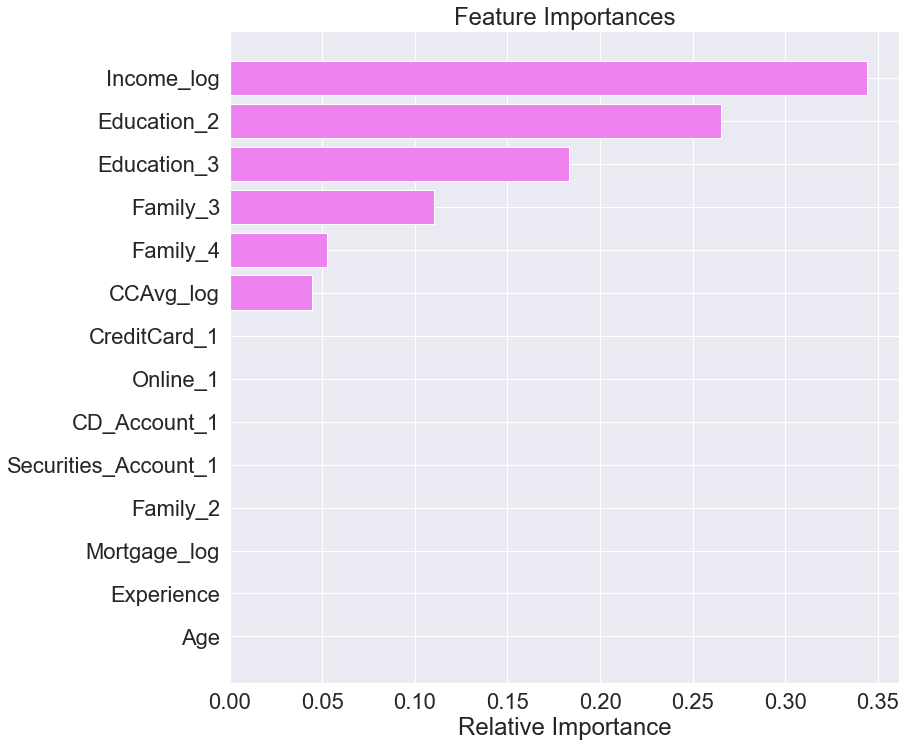

In [122]:
importances = best_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

* income and Education are most important features

In [123]:
comparison_frame = pd.DataFrame({'Model':['Initial decision tree model','Decision tree with restricted maximum depth','Decision treee with hyperparameter tuning',
                                         'Decision tree with post-pruning'], 'Train_precision':[1.0,1.0,0.97,1.0], 'Test_Precision':[0.91,1.0,0.94,1.0]}) 
comparison_frame

Model  Train_precision  \
0                  Initial decision tree model          1.00000   
1  Decision tree with restricted maximum depth          1.00000   
2    Decision treee with hyperparameter tuning          0.97000   
3              Decision tree with post-pruning          1.00000   

   Test_Precision  
0         0.91000  
1         1.00000  
2         0.94000  
3         1.00000

# Conclusion and Recommendations

* Able to build good predictive decision tree model. Clearly we can understand that Income, Education having 2 & 3 levels, Family count 3 & 4 , CCAvg are important features to predict Personal_loan target.
* From the above we can understand that personal loan can be offered to the people who fall under below critirian     * people with good income.
  * people who has significant amount of credit card usage per month.
  * customers with family size of 3 or 4.
  * Customers with good education level (graduate or above)
  
  
- I would recommend that bank could target the customers who fall under above criterian for better loan offers to imrpove the business.